In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import mlflow
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from lib import full_flow_dataloader
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold
from lib.config import AppConfig
from lib.data_handling import load_split_data, CustomSpectralPipeline, WavelengthMaskTransformer, NonNegativeTransformer, SpectralDataReshaper
from lib.reproduction import major_oxides, masks

from lib.norms import Norm1Scaler, Norm3Scaler


In [3]:
class VarianceThresholdTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.0):
        self.threshold = threshold

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X = X.values  # Ensure handling as numpy array
        self.variances_ = np.var(X, axis=1)  # Calculate variances row-wise
        print("Calculated variances:", self.variances_)  # Debug: Output the variances
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values

        # Debug: Ensure the shape and type of variances are correct
        print("Variances on transform:", self.variances_)
        print("Threshold:", self.threshold)

        rows_to_zero_out = self.variances_ < self.threshold
        print("Rows to zero out (mask):", rows_to_zero_out)  # Which rows are marked to zero out

        X_transformed = np.copy(X)
        X_transformed[rows_to_zero_out, :] = 0

        # Debug: Number of rows actually zeroed out
        print(f"Number of rows zeroed out: {np.sum(rows_to_zero_out)}")

        return X_transformed

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)


In [92]:
config = AppConfig()

composition_data_loc = config.composition_data_path
dataset_loc = config.data_path

# if not train_data or not test_data: # type: ignore
train_data, test_data = load_split_data(
	str(dataset_loc), average_shots=True
)

Loading data: 100%|██████████| 414/414 [00:22<00:00, 18.22it/s]


In [93]:
pipeline = CustomSpectralPipeline(
	masks=masks,
	composition_data_loc=composition_data_loc,
	major_oxides=major_oxides,
)

# pipeline.pipeline.steps.insert(-2, ('variance_threshold', VarianceThresholdTransformer(threshold=0)))
# pipeline.pipeline.steps.append(('variance_threshold', VarianceThresholdTransformer(threshold=0.9)))

train_processed = pipeline.fit_transform(train_data)
test_processed = pipeline.fit_transform(test_data)


Transforming samples:   0%|          | 0/308 [00:00<?, ?it/s]

Transforming samples: 100%|██████████| 78/78 [00:03<00:00, 23.34it/s]


In [106]:
scaler = Norm3Scaler()
train_processed = scaler.fit_transform(train_processed)
test_processed = scaler.transform(test_processed)

In [94]:
train_processed.iloc[:, 200:300]

,251.45399,251.506,251.558,251.612,251.664,251.716,251.77,251.823,251.875,251.92799,...,256.181,256.233,256.285,256.33801,256.39001,256.44101,256.495,256.547,256.599,256.64999
0,9.864223e+11,1.283051e+12,1.446894e+12,1.662103e+12,1.923722e+12,1.866667e+12,1.274945e+12,8.138546e+11,7.603231e+11,8.702122e+11,...,2.055250e+11,3.500348e+11,5.545744e+11,7.313358e+11,6.843560e+11,4.679429e+11,2.780677e+11,1.653261e+11,1.627443e+11,1.725966e+11
1,9.340033e+11,1.195670e+12,1.331225e+12,1.533589e+12,1.764239e+12,1.713824e+12,1.185696e+12,7.686207e+11,7.199318e+11,8.200800e+11,...,2.113141e+11,3.569021e+11,5.563103e+11,7.183242e+11,6.631527e+11,4.534475e+11,2.681449e+11,1.552175e+11,1.572471e+11,1.672647e+11
2,1.068447e+12,1.387753e+12,1.546457e+12,1.788038e+12,2.082432e+12,2.002366e+12,1.356910e+12,8.704779e+11,8.152674e+11,9.348677e+11,...,2.105661e+11,3.587259e+11,5.745650e+11,7.609672e+11,7.220627e+11,4.937088e+11,2.912892e+11,1.749739e+11,1.726100e+11,1.808504e+11
3,1.121378e+12,1.457785e+12,1.633324e+12,1.876318e+12,2.187772e+12,2.122826e+12,1.425465e+12,9.047725e+11,8.460525e+11,9.701102e+11,...,2.212724e+11,3.727815e+11,5.998696e+11,7.948871e+11,7.468635e+11,5.111497e+11,2.994250e+11,1.767438e+11,1.780473e+11,1.851622e+11
4,9.975943e+11,1.292387e+12,1.447840e+12,1.650085e+12,1.902704e+12,1.826214e+12,1.269562e+12,8.640144e+11,8.108526e+11,9.042491e+11,...,2.682707e+11,4.533201e+11,7.376671e+11,9.783386e+11,9.242172e+11,6.347349e+11,3.763932e+11,2.325430e+11,2.257815e+11,2.409430e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1533,9.506193e+11,1.180871e+12,1.317148e+12,1.475714e+12,1.731064e+12,1.769919e+12,1.234682e+12,7.495081e+11,7.214264e+11,8.224720e+11,...,9.382661e+10,1.498440e+11,2.205922e+11,3.083025e+11,2.724146e+11,1.758873e+11,1.006016e+11,4.073272e+10,2.713110e+10,3.412601e+10
1534,9.937543e+11,1.250863e+12,1.398204e+12,1.570468e+12,1.851645e+12,1.896586e+12,1.299680e+12,7.553773e+11,7.266579e+11,8.416468e+11,...,7.418376e+10,1.104506e+11,1.593049e+11,2.209218e+11,1.892229e+11,1.252323e+11,7.313297e+10,3.285690e+10,2.243204e+10,2.559275e+10
1535,1.081016e+12,1.333999e+12,1.485179e+12,1.665291e+12,1.930948e+12,1.971524e+12,1.397003e+12,8.825402e+11,8.427643e+11,9.501161e+11,...,1.375247e+11,2.278977e+11,3.318931e+11,4.519318e+11,4.081070e+11,2.647552e+11,1.573848e+11,6.502384e+10,5.709795e+10,6.754603e+10
1536,9.476923e+11,1.185034e+12,1.320686e+12,1.482550e+12,1.734794e+12,1.780499e+12,1.223831e+12,7.286955e+11,6.994471e+11,8.082712e+11,...,7.494205e+10,1.159219e+11,1.665239e+11,2.326714e+11,1.976693e+11,1.302759e+11,7.667984e+10,3.708962e+10,2.319821e+10,2.541582e+10


In [95]:
def drop_non_numeric_columns(df: pd.DataFrame) -> pd.DataFrame:
	cols_to_drop = major_oxides + ["Sample Name", "ID"]
	return df.drop(columns=cols_to_drop)

In [142]:
def generate_exponential_quantiles(min_quantile, max_quantile, num_points):
    return np.linspace(min_quantile, max_quantile, num_points)
    # # Generate linearly spaced values in the exponent space between log(min_quantile) and log(max_quantile)
    # exponent_space = np.linspace(np.log(min_quantile), np.log(max_quantile), num_points)

    # # Calculate the actual quantiles
    # quantiles = np.exp(exponent_space)

    # return quantiles

min_q = 1e-9  # starting quantile
max_q = 0.05   # ending quantile
points = 100   # number of points

quantile_values = generate_exponential_quantiles(min_q, max_q, points)
print(quantile_values)

[1.00000000e-09 5.05051495e-04 1.01010199e-03 1.51515248e-03
 2.02020298e-03 2.52525347e-03 3.03030397e-03 3.53535446e-03
 4.04040496e-03 4.54545545e-03 5.05050595e-03 5.55555644e-03
 6.06060694e-03 6.56565743e-03 7.07070793e-03 7.57575842e-03
 8.08080892e-03 8.58585941e-03 9.09090991e-03 9.59596040e-03
 1.01010109e-02 1.06060614e-02 1.11111119e-02 1.16161624e-02
 1.21212129e-02 1.26262634e-02 1.31313139e-02 1.36363644e-02
 1.41414149e-02 1.46464654e-02 1.51515158e-02 1.56565663e-02
 1.61616168e-02 1.66666673e-02 1.71717178e-02 1.76767683e-02
 1.81818188e-02 1.86868693e-02 1.91919198e-02 1.96969703e-02
 2.02020208e-02 2.07070713e-02 2.12121218e-02 2.17171723e-02
 2.22222228e-02 2.27272733e-02 2.32323238e-02 2.37373743e-02
 2.42424248e-02 2.47474753e-02 2.52525257e-02 2.57575762e-02
 2.62626267e-02 2.67676772e-02 2.72727277e-02 2.77777782e-02
 2.82828287e-02 2.87878792e-02 2.92929297e-02 2.97979802e-02
 3.03030307e-02 3.08080812e-02 3.13131317e-02 3.18181822e-02
 3.23232327e-02 3.282828

In [143]:
# Calculate the upper and lower quantiles of the test data
pd.set_option('display.precision', 10)
pd.set_option('display.float_format', '{:.10f}'.format)

train = drop_non_numeric_columns(train_processed)
test = drop_non_numeric_columns(test_processed)

zero_sum_columns = train.columns[train.sum() == 0]
test_no_zero_columns = test.drop(columns=zero_sum_columns)

flattened_series = test_no_zero_columns.values.ravel()
quantiles = pd.Series(flattened_series).quantile(quantile_values)
quantiles

0.0000000010   0.0000000000
0.0005050515   0.0000000000
0.0010101020   0.0000000000
0.0015151525   0.0000000000
0.0020202030   0.0000000000
                   ...     
0.0479797980   0.0000168803
0.0484848485   0.0000170460
0.0489898990   0.0000172172
0.0494949495   0.0000173721
0.0500000000   0.0000175345
Length: 100, dtype: float64

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


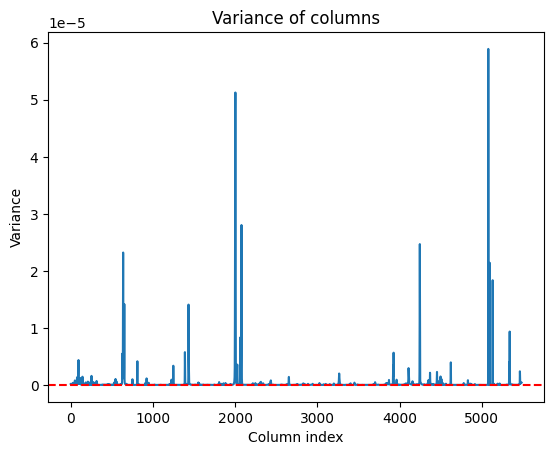

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


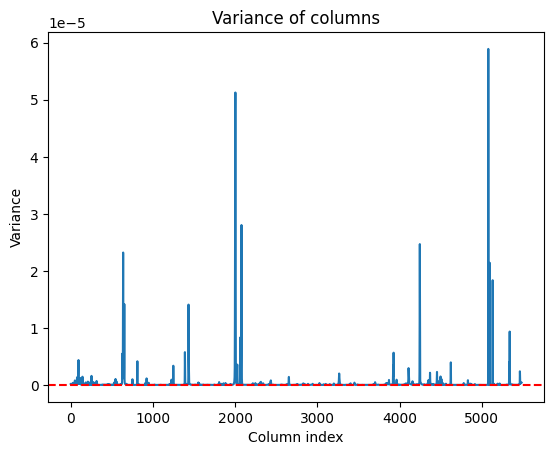

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


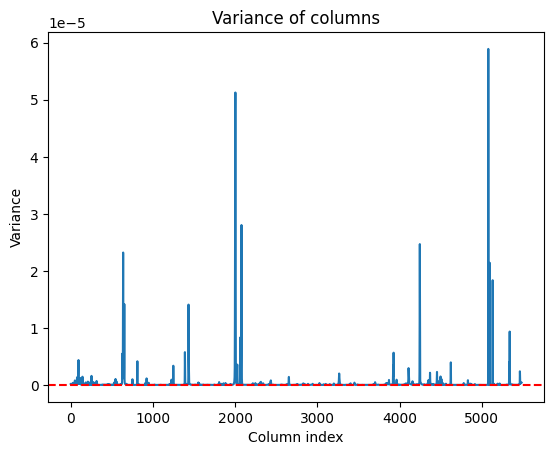

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


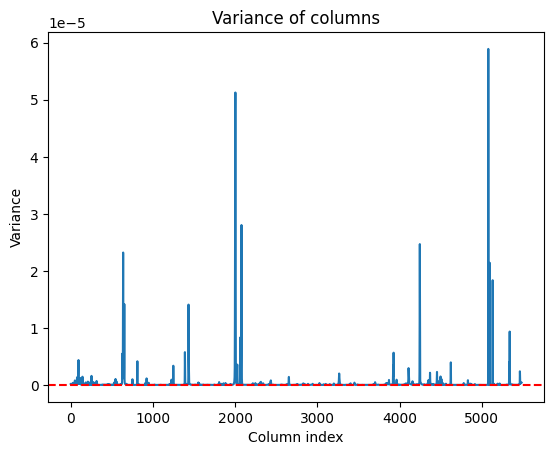

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


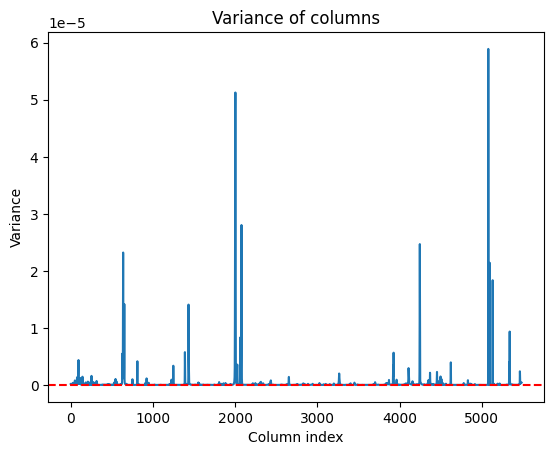

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


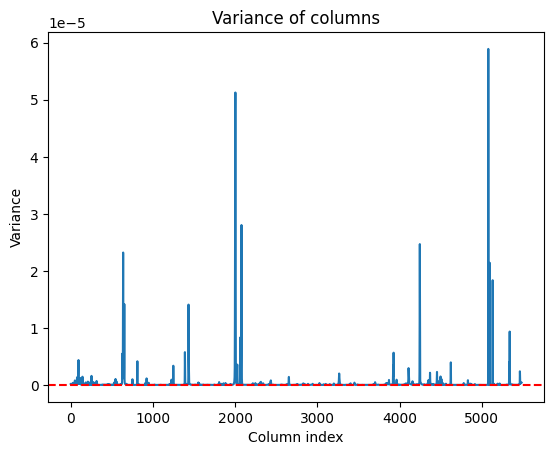

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


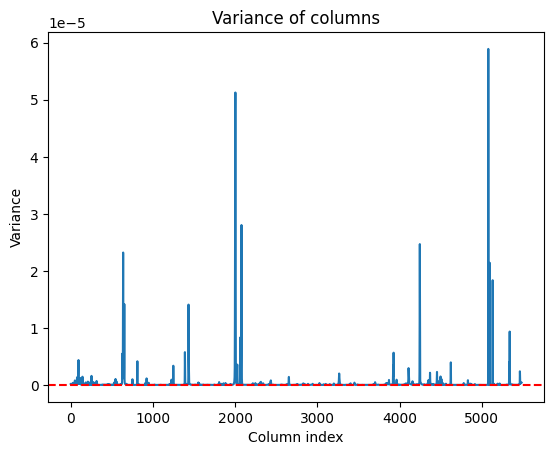

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


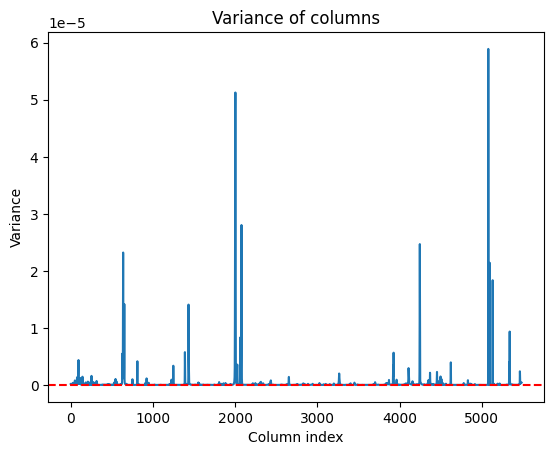

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


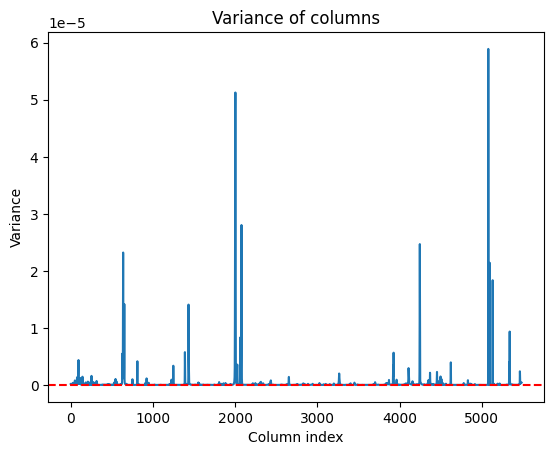

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


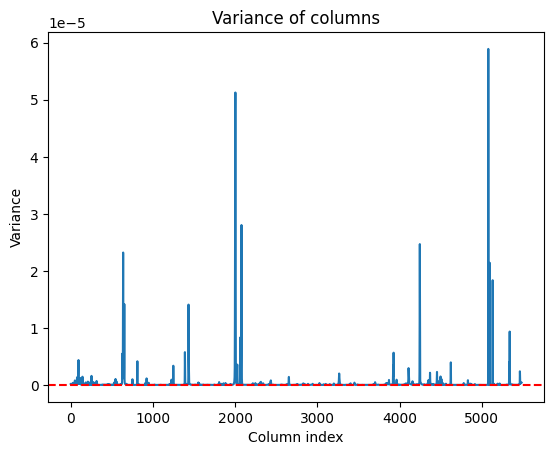

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


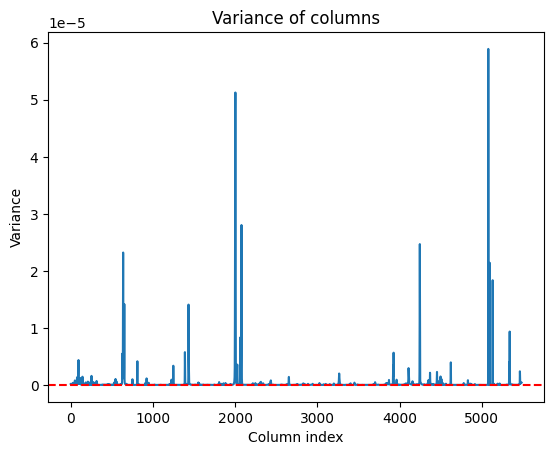

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


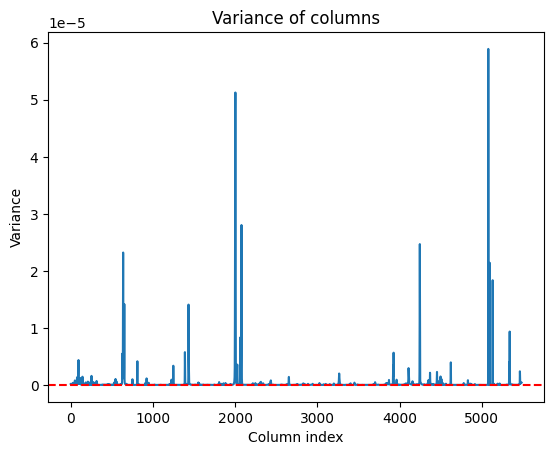

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


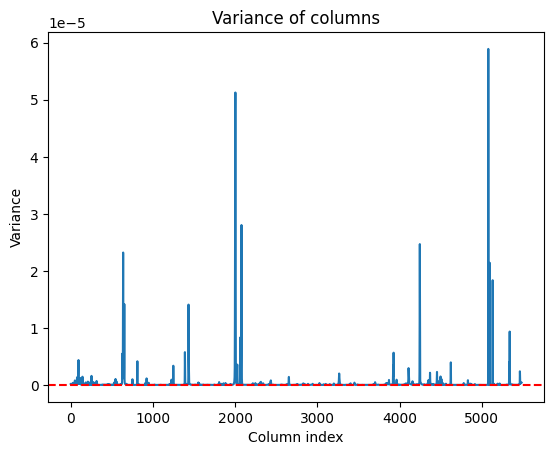

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


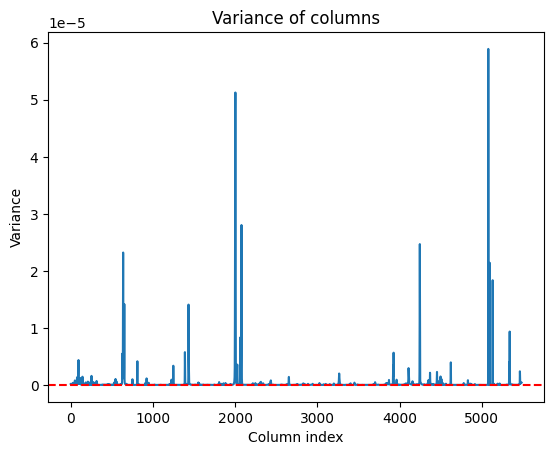

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


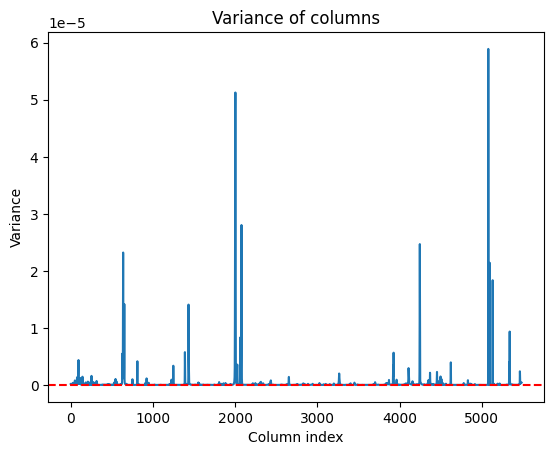

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


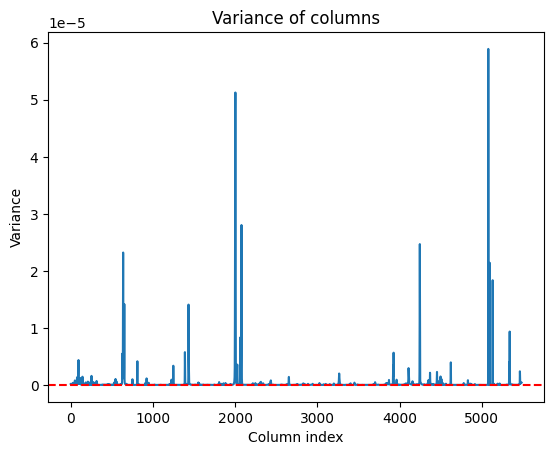

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


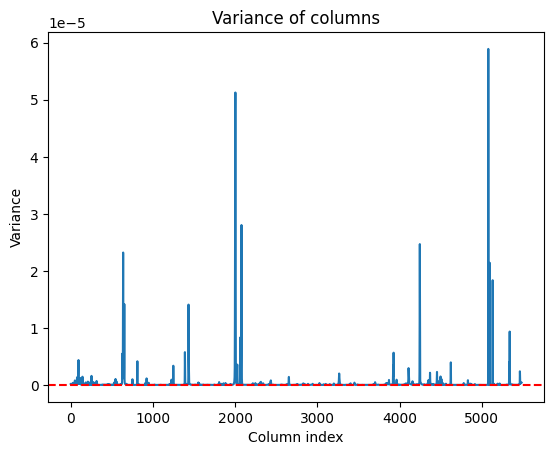

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


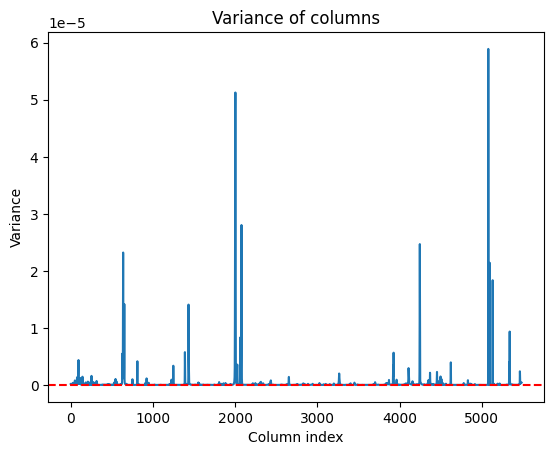

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


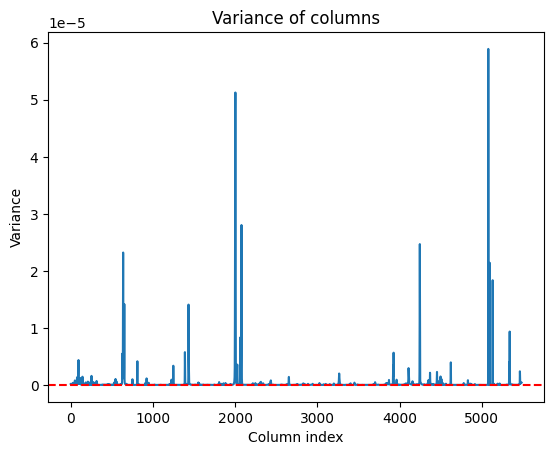

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


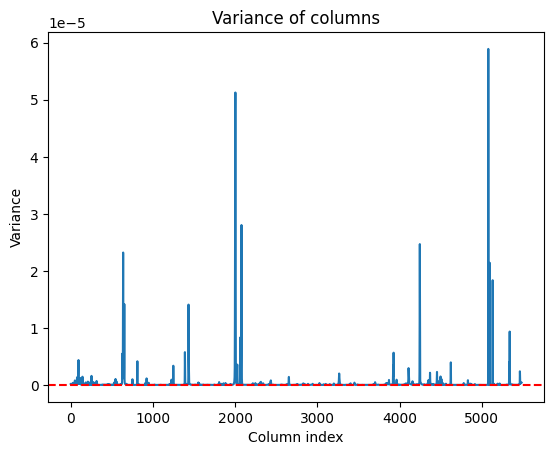

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


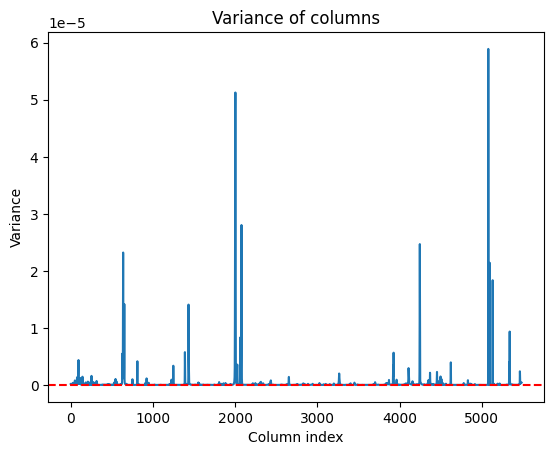

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


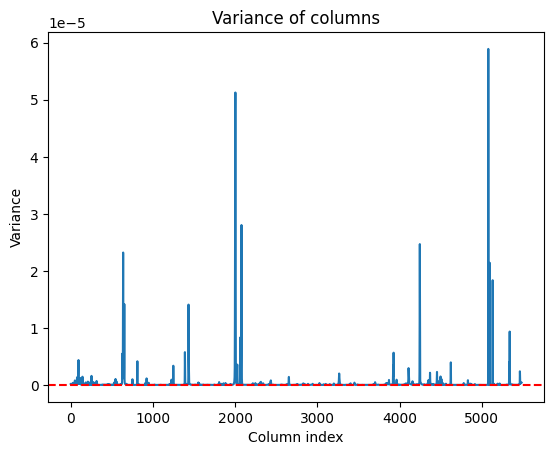

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


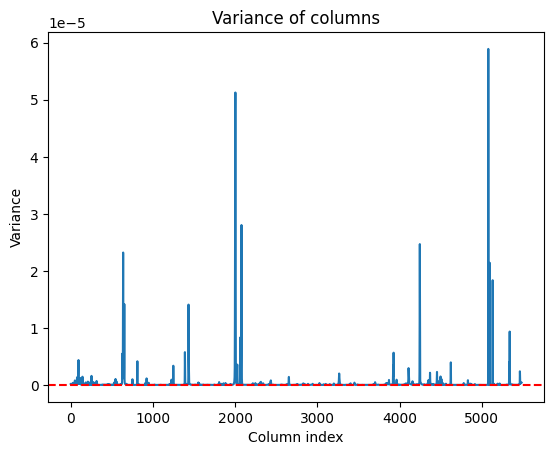

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


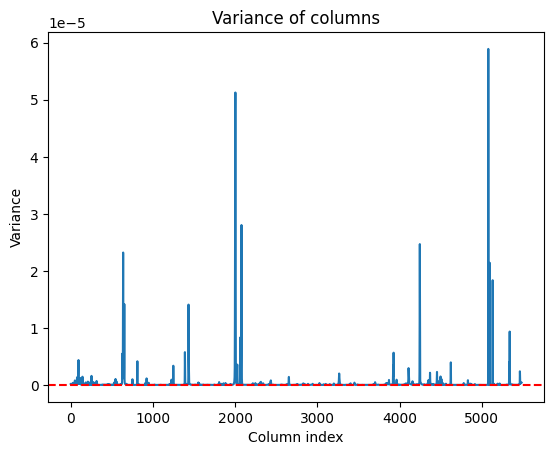

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


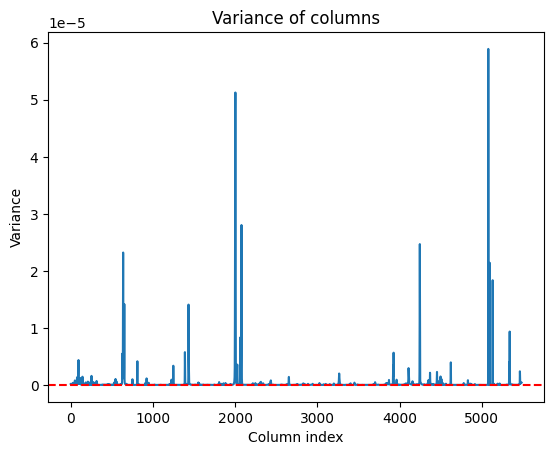

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


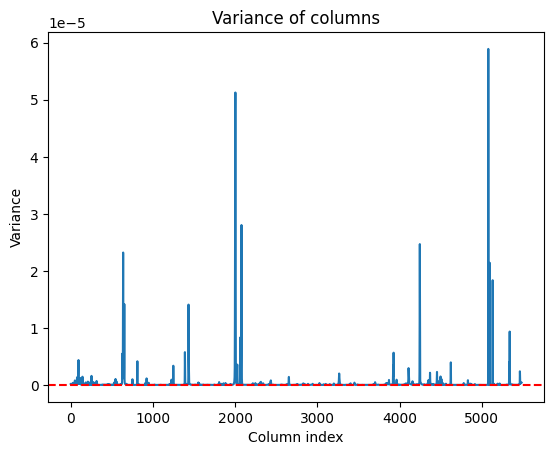

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


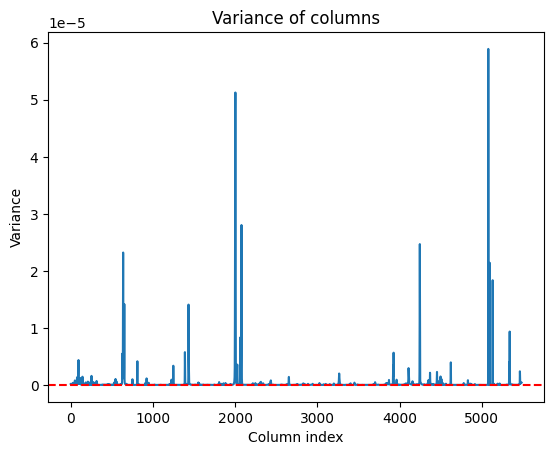

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


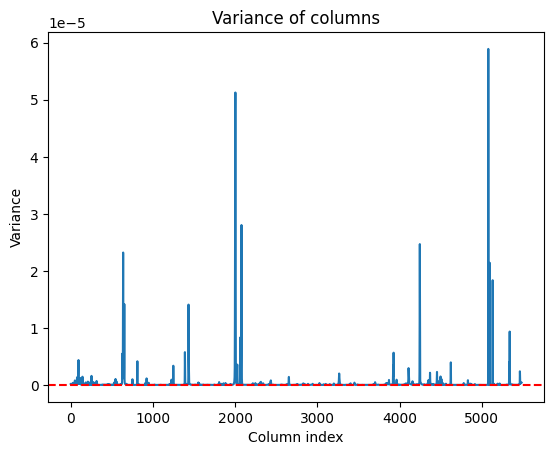

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


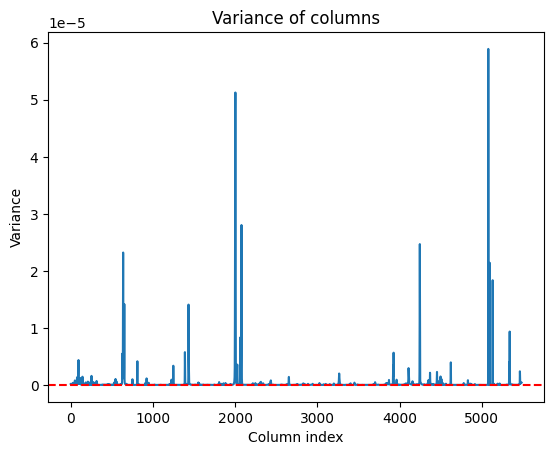

Threshold: 0.0
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 6144)
Transformed Test data shape: (390, 6144)
Sum: 4614.0
Number of columns dropped due to zero variance: 0


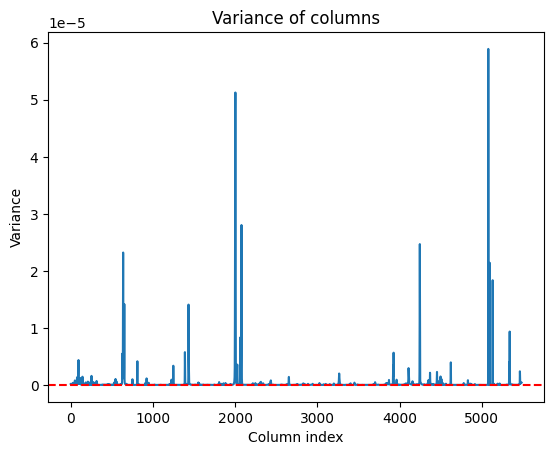

Threshold: 1.5028697920389632e-07
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 1486)
Transformed Test data shape: (390, 1486)
Sum: 2505.8342861978795
Number of columns dropped due to zero variance: 4658


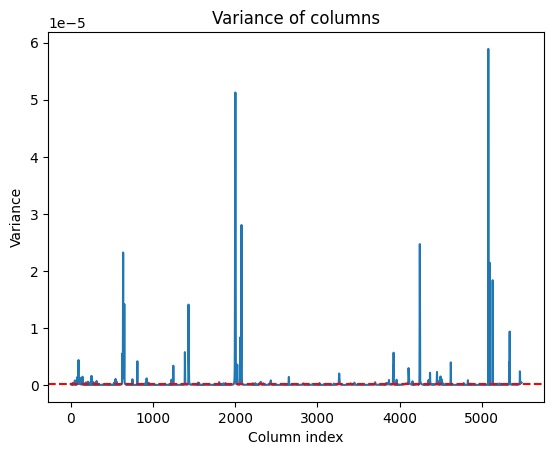

Threshold: 9.869236219032675e-07
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 855)
Transformed Test data shape: (390, 855)
Sum: 1354.3338340616942
Number of columns dropped due to zero variance: 5289


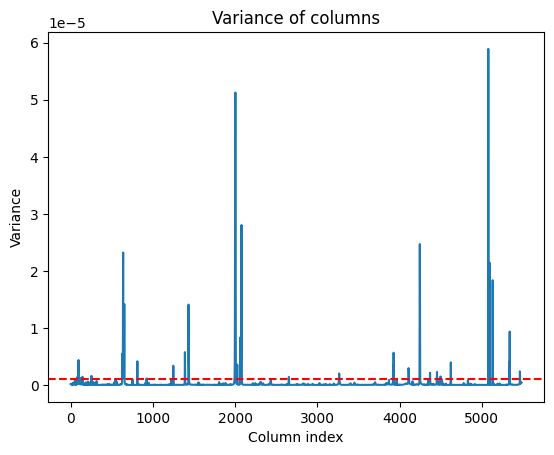

Threshold: 1.7335356450831257e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 799)
Transformed Test data shape: (390, 799)
Sum: 1156.1767672762458
Number of columns dropped due to zero variance: 5345


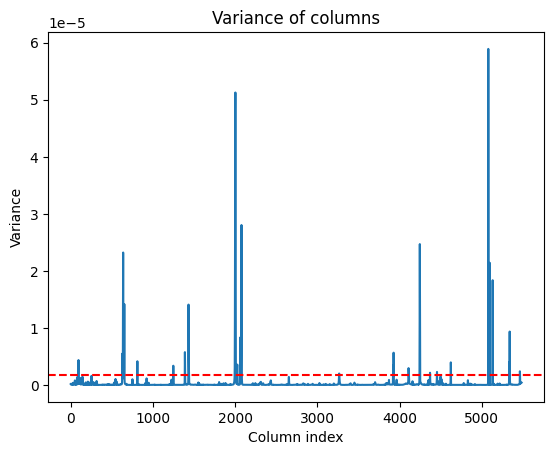

Threshold: 2.3795594873404087e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 770)
Transformed Test data shape: (390, 770)
Sum: 1037.485098703845
Number of columns dropped due to zero variance: 5374


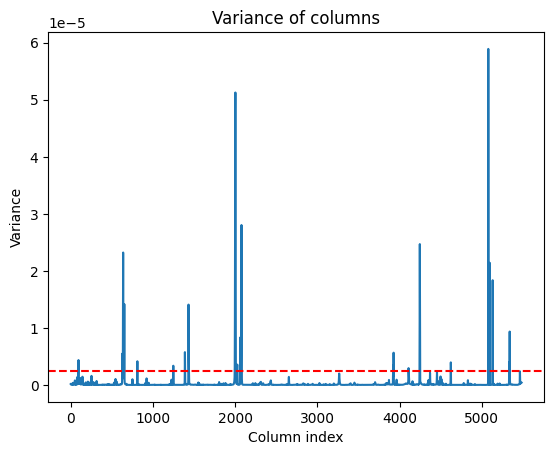

Threshold: 2.95721808388505e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 755)
Transformed Test data shape: (390, 755)
Sum: 950.2050152489264
Number of columns dropped due to zero variance: 5389


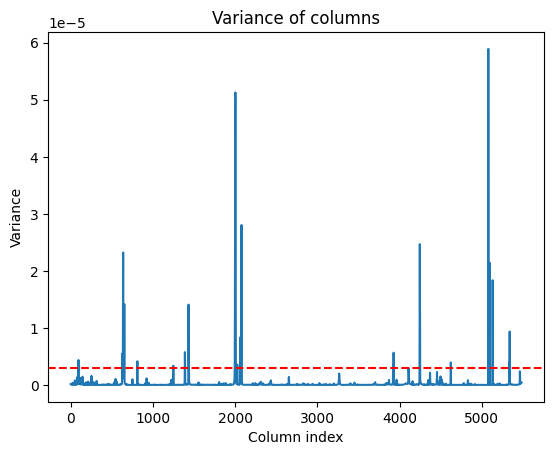

Threshold: 3.4579726303049545e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 743)
Transformed Test data shape: (390, 743)
Sum: 887.1355226106059
Number of columns dropped due to zero variance: 5401


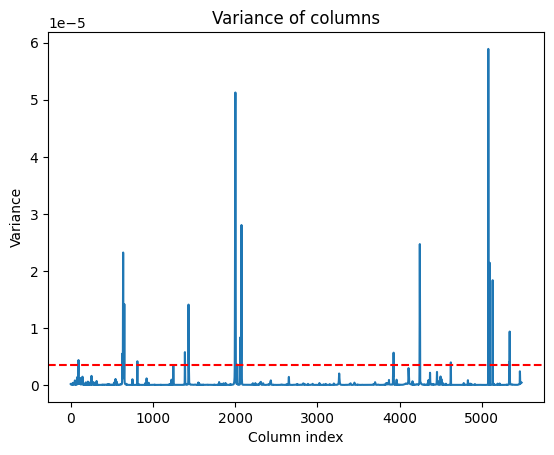

Threshold: 3.911310954350278e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 737)
Transformed Test data shape: (390, 737)
Sum: 860.4260965167082
Number of columns dropped due to zero variance: 5407


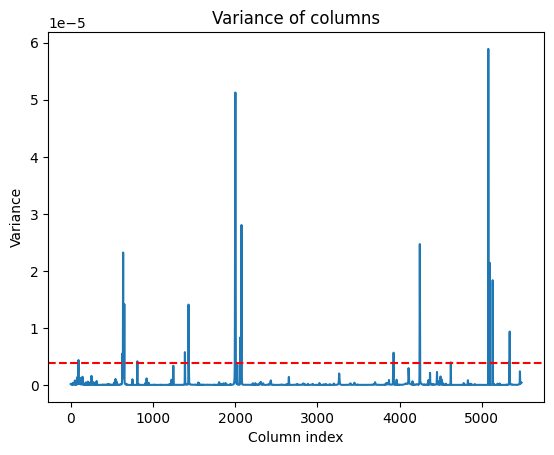

Threshold: 4.350724233406427e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 727)
Transformed Test data shape: (390, 727)
Sum: 796.7215173998609
Number of columns dropped due to zero variance: 5417


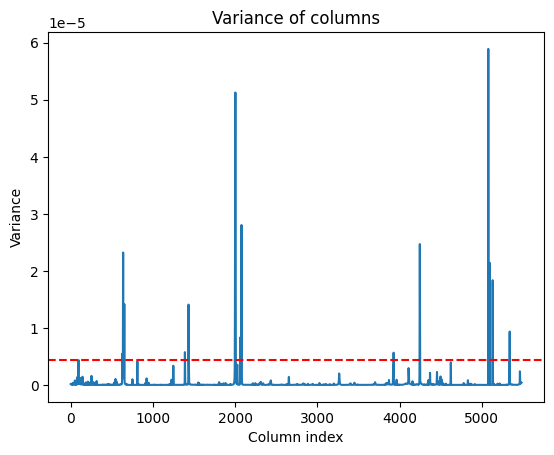

Threshold: 4.755509160024313e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 725)
Transformed Test data shape: (390, 725)
Sum: 783.1041082384226
Number of columns dropped due to zero variance: 5419


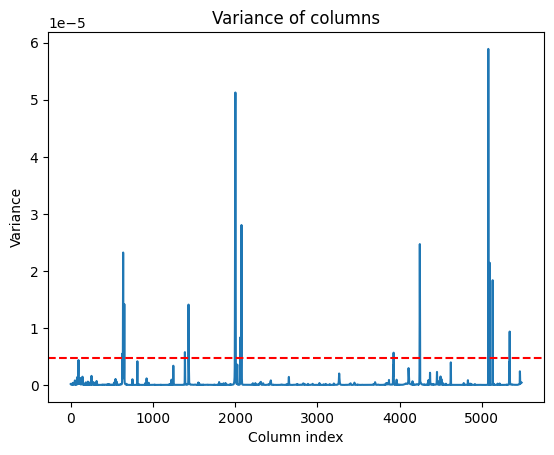

Threshold: 5.1337798845905295e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 721)
Transformed Test data shape: (390, 721)
Sum: 760.3742772310592
Number of columns dropped due to zero variance: 5423


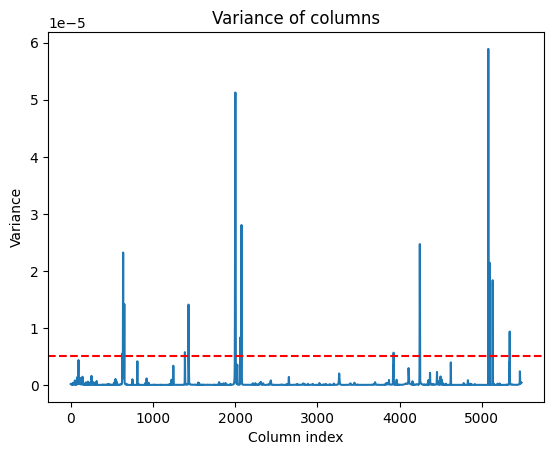

Threshold: 5.500916496317853e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 717)
Transformed Test data shape: (390, 717)
Sum: 736.2123892016276
Number of columns dropped due to zero variance: 5427


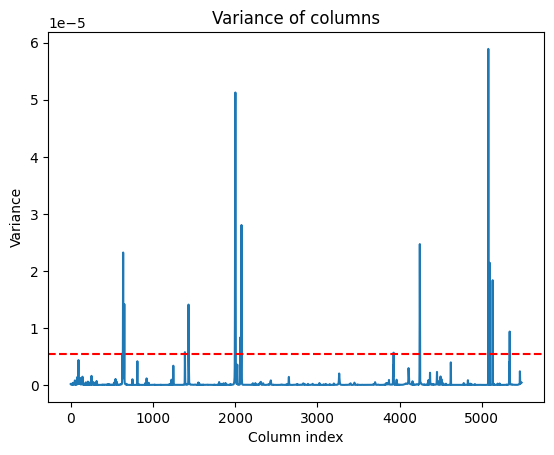

Threshold: 5.84511666316555e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 712)
Transformed Test data shape: (390, 712)
Sum: 713.5449924888172
Number of columns dropped due to zero variance: 5432


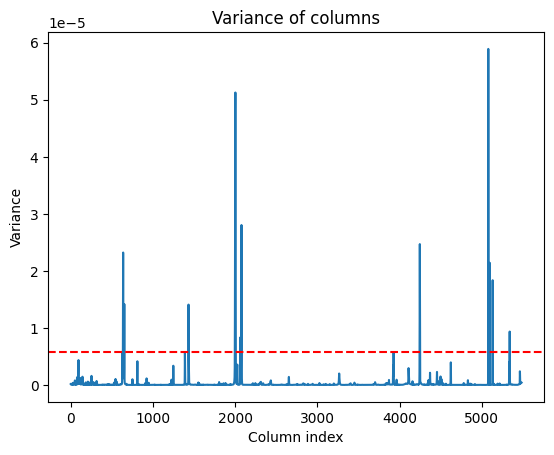

Threshold: 6.172616318644855e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 712)
Transformed Test data shape: (390, 712)
Sum: 713.5449924888172
Number of columns dropped due to zero variance: 5432


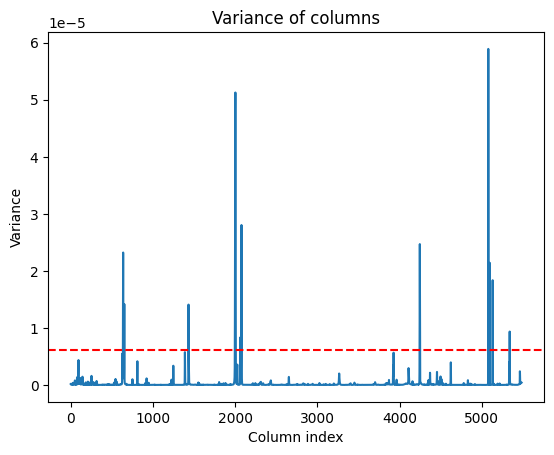

Threshold: 6.480862667425826e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 711)
Transformed Test data shape: (390, 711)
Sum: 704.2157407124249
Number of columns dropped due to zero variance: 5433


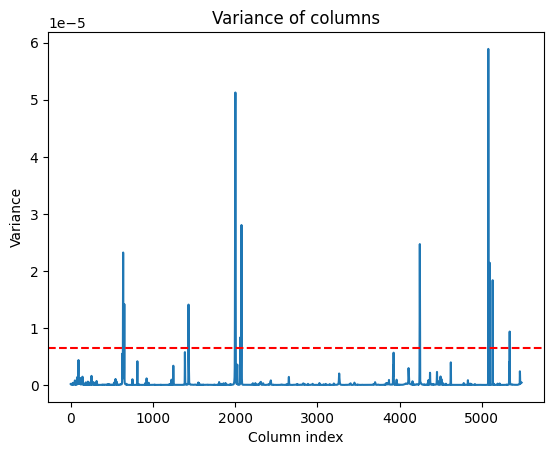

Threshold: 6.795343345832444e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 709)
Transformed Test data shape: (390, 709)
Sum: 684.7297007132747
Number of columns dropped due to zero variance: 5435


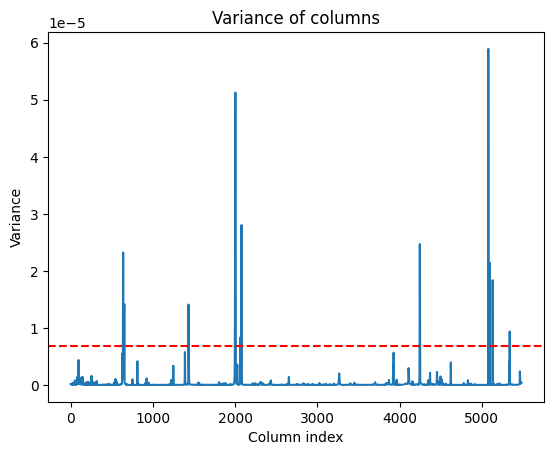

Threshold: 7.078328826002507e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 709)
Transformed Test data shape: (390, 709)
Sum: 684.7297007132747
Number of columns dropped due to zero variance: 5435


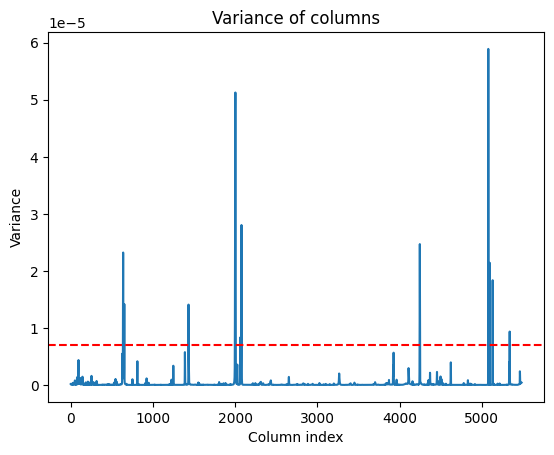

Threshold: 7.366394750367459e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 709)
Transformed Test data shape: (390, 709)
Sum: 684.7297007132747
Number of columns dropped due to zero variance: 5435


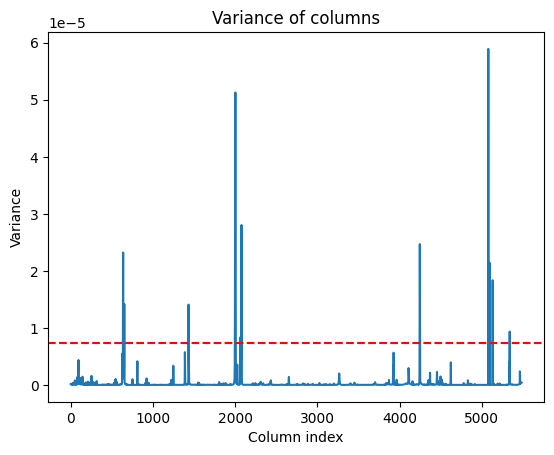

Threshold: 7.659413975395388e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 707)
Transformed Test data shape: (390, 707)
Sum: 664.9130160814018
Number of columns dropped due to zero variance: 5437


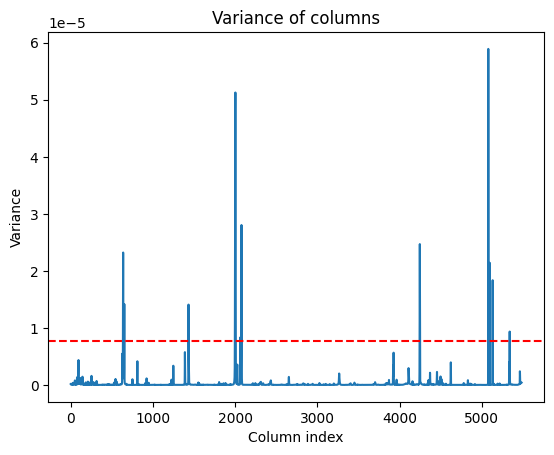

Threshold: 7.922057307353381e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 707)
Transformed Test data shape: (390, 707)
Sum: 664.9130160814018
Number of columns dropped due to zero variance: 5437


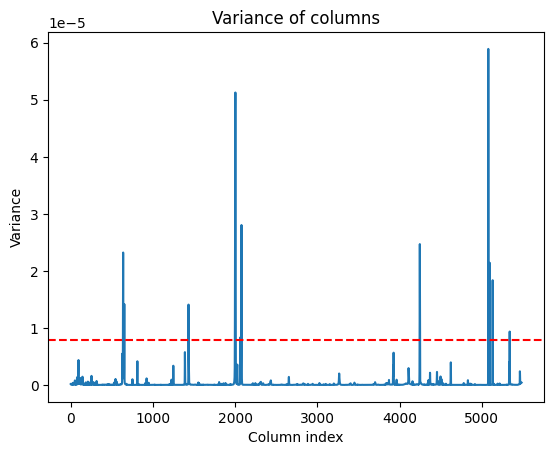

Threshold: 8.18282125793653e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 706)
Transformed Test data shape: (390, 706)
Sum: 654.0114179081986
Number of columns dropped due to zero variance: 5438


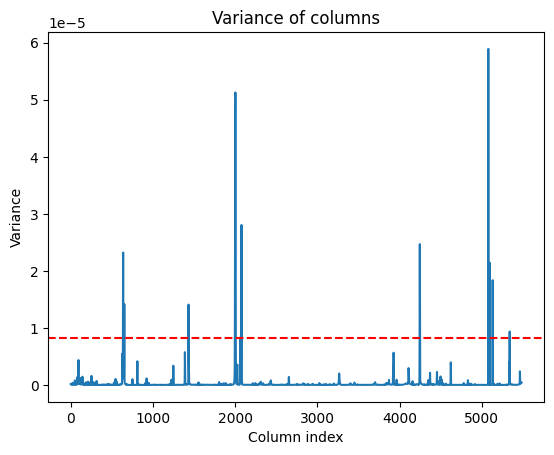

Threshold: 8.438143962273488e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 705)
Transformed Test data shape: (390, 705)
Sum: 643.0970827228045
Number of columns dropped due to zero variance: 5439


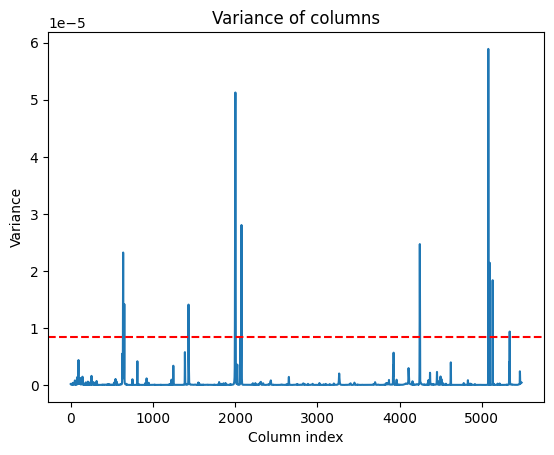

Threshold: 8.68644307571987e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 704)
Transformed Test data shape: (390, 704)
Sum: 634.3199005035702
Number of columns dropped due to zero variance: 5440


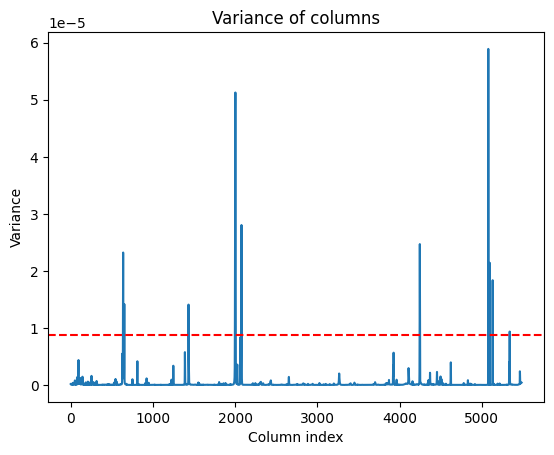

Threshold: 8.925975650166697e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 704)
Transformed Test data shape: (390, 704)
Sum: 634.3199005035702
Number of columns dropped due to zero variance: 5440


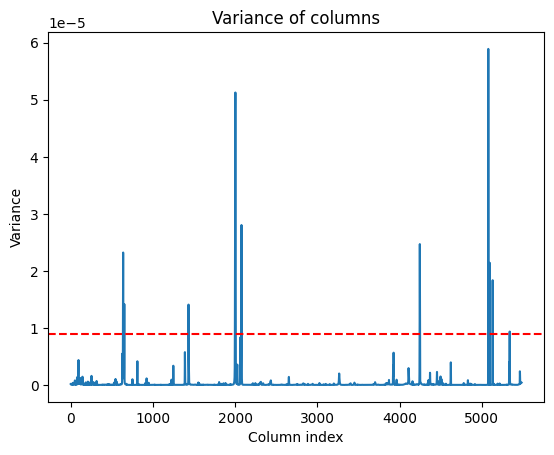

Threshold: 9.167979727914831e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 703)
Transformed Test data shape: (390, 703)
Sum: 630.7599427449525
Number of columns dropped due to zero variance: 5441


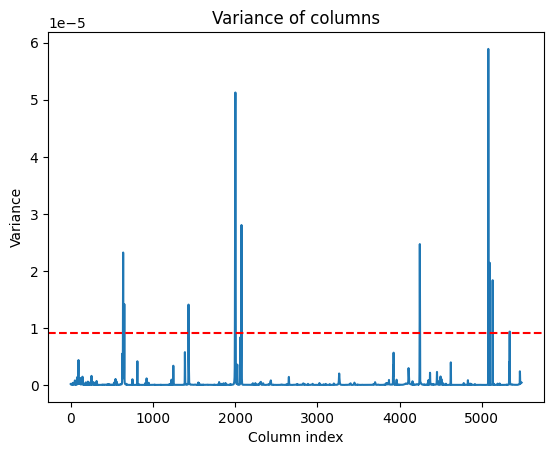

Threshold: 9.402439751739898e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 700)
Transformed Test data shape: (390, 700)
Sum: 607.7353417955128
Number of columns dropped due to zero variance: 5444


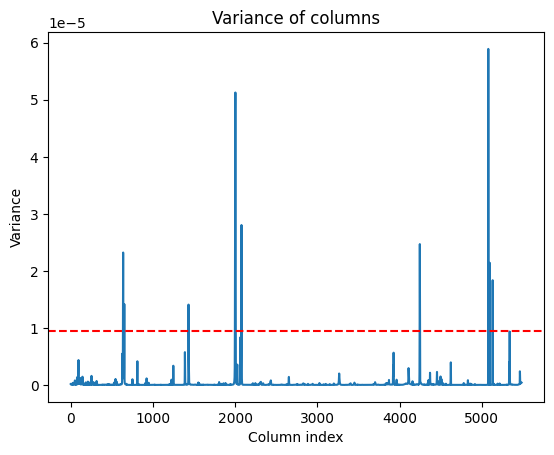

Threshold: 9.622526414101478e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 700)
Transformed Test data shape: (390, 700)
Sum: 607.7353417955128
Number of columns dropped due to zero variance: 5444


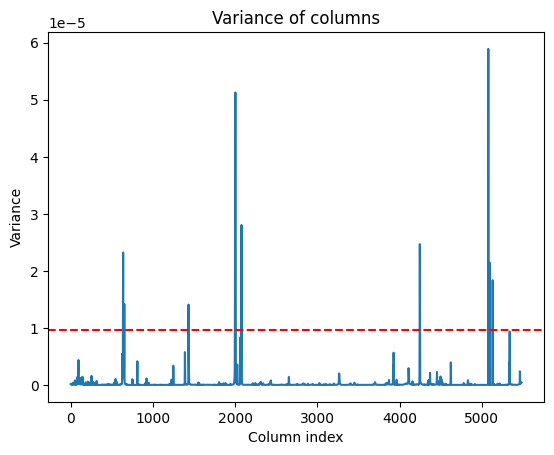

Threshold: 9.840659721699537e-06
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 700)
Transformed Test data shape: (390, 700)
Sum: 607.7353417955128
Number of columns dropped due to zero variance: 5444


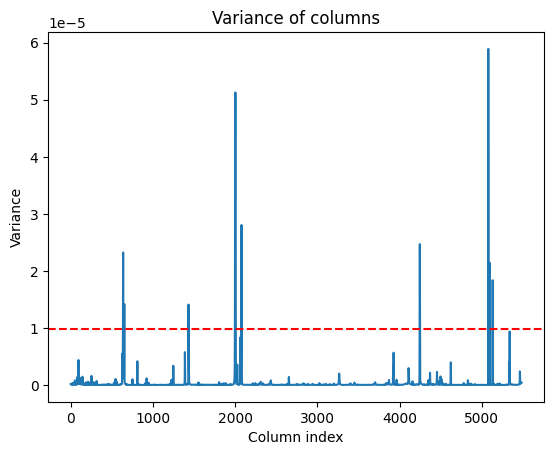

Threshold: 1.007038522235301e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 699)
Transformed Test data shape: (390, 699)
Sum: 598.6598915132902
Number of columns dropped due to zero variance: 5445


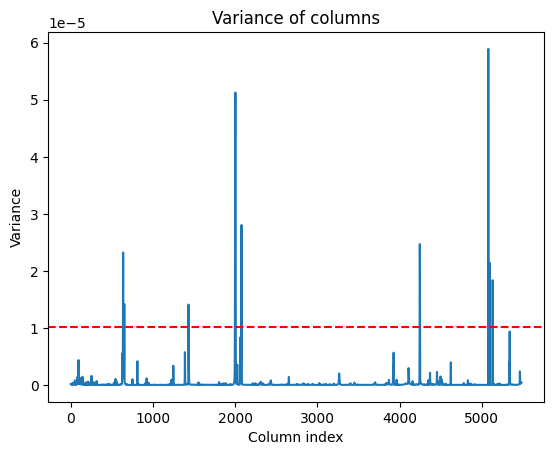

Threshold: 1.0292535359995436e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 698)
Transformed Test data shape: (390, 698)
Sum: 567.5771523618004
Number of columns dropped due to zero variance: 5446


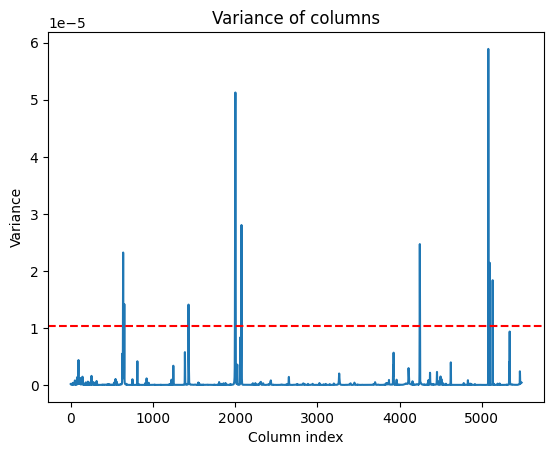

Threshold: 1.051328000416528e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 698)
Transformed Test data shape: (390, 698)
Sum: 567.5771523618004
Number of columns dropped due to zero variance: 5446


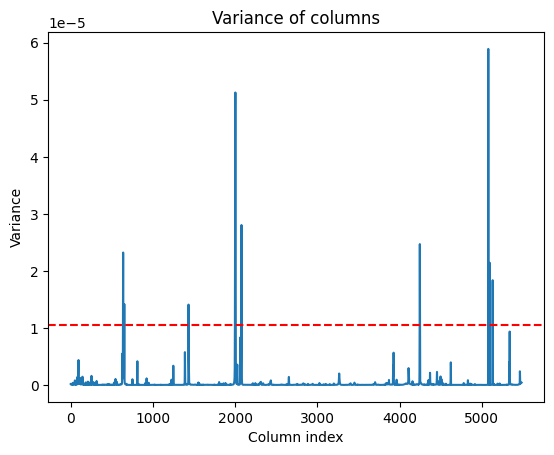

Threshold: 1.0722385306620853e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 698)
Transformed Test data shape: (390, 698)
Sum: 567.5771523618004
Number of columns dropped due to zero variance: 5446


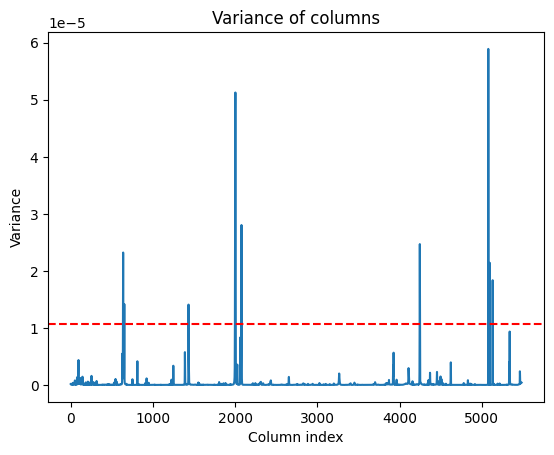

Threshold: 1.0936923967103474e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 697)
Transformed Test data shape: (390, 697)
Sum: 560.921371729097
Number of columns dropped due to zero variance: 5447


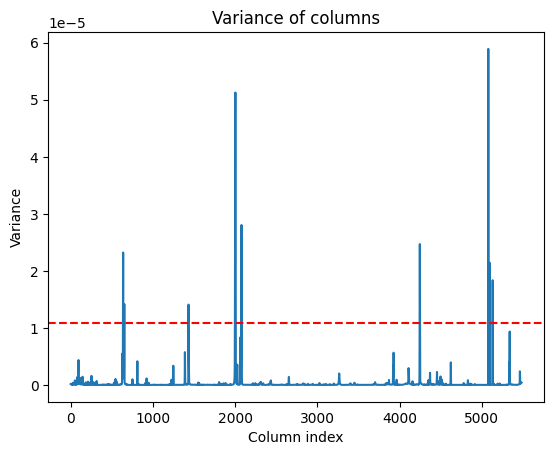

Threshold: 1.1137190353179313e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 695)
Transformed Test data shape: (390, 695)
Sum: 544.7854251385561
Number of columns dropped due to zero variance: 5449


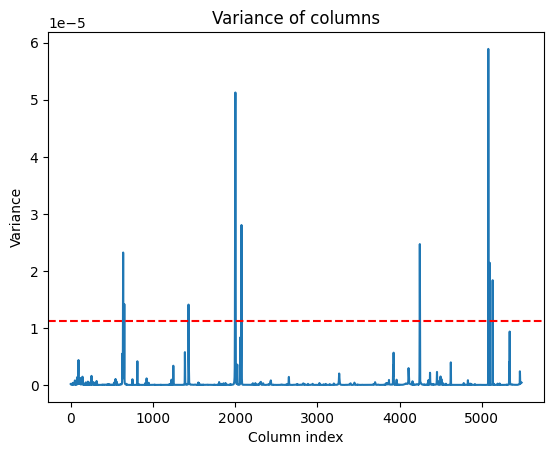

Threshold: 1.1331982178079707e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 695)
Transformed Test data shape: (390, 695)
Sum: 544.7854251385561
Number of columns dropped due to zero variance: 5449


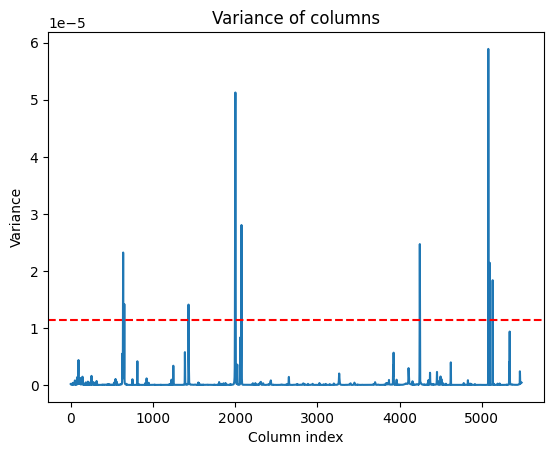

Threshold: 1.152945174676388e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 694)
Transformed Test data shape: (390, 694)
Sum: 535.2319990320029
Number of columns dropped due to zero variance: 5450


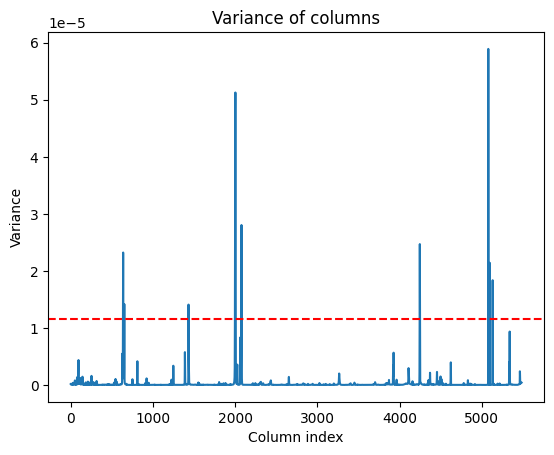

Threshold: 1.1717262808522633e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 693)
Transformed Test data shape: (390, 693)
Sum: 531.1206225562523
Number of columns dropped due to zero variance: 5451


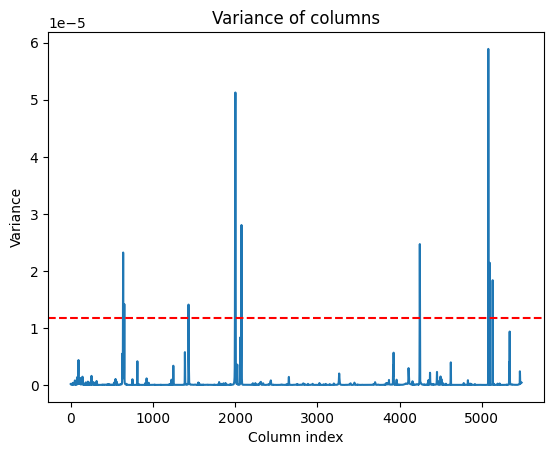

Threshold: 1.1902349994177024e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 693)
Transformed Test data shape: (390, 693)
Sum: 531.1206225562523
Number of columns dropped due to zero variance: 5451


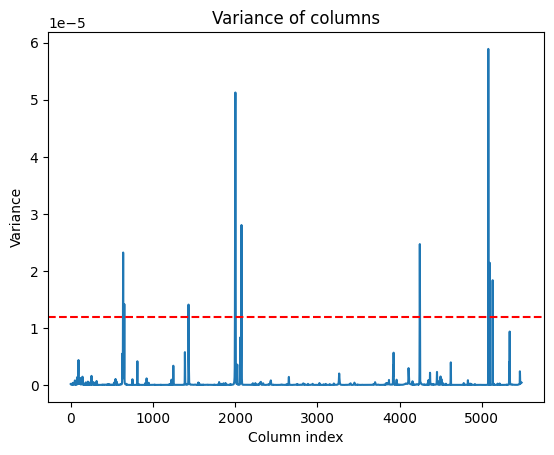

Threshold: 1.2078889521411116e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 693)
Transformed Test data shape: (390, 693)
Sum: 531.1206225562523
Number of columns dropped due to zero variance: 5451


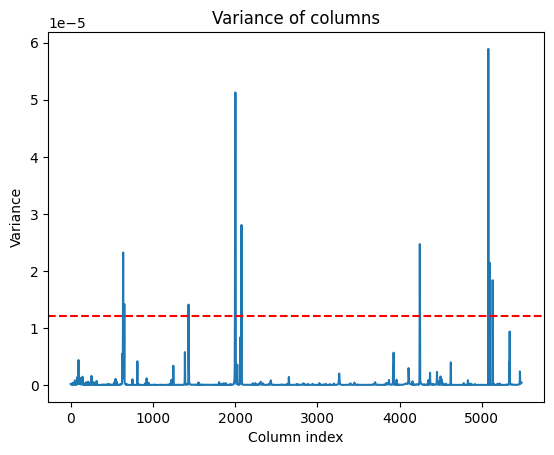

Threshold: 1.2279161740898995e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 692)
Transformed Test data shape: (390, 692)
Sum: 519.8813781981182
Number of columns dropped due to zero variance: 5452


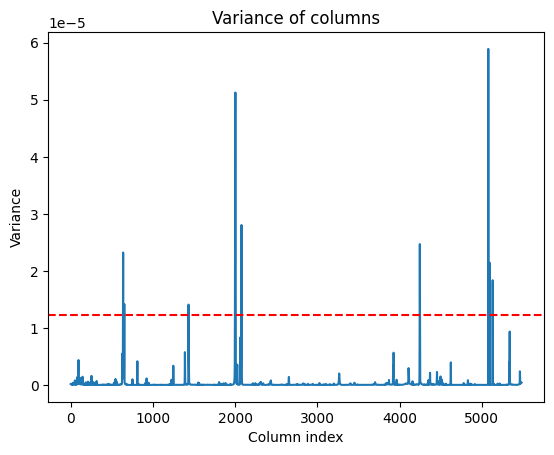

Threshold: 1.246238838334974e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 691)
Transformed Test data shape: (390, 691)
Sum: 509.9585543058489
Number of columns dropped due to zero variance: 5453


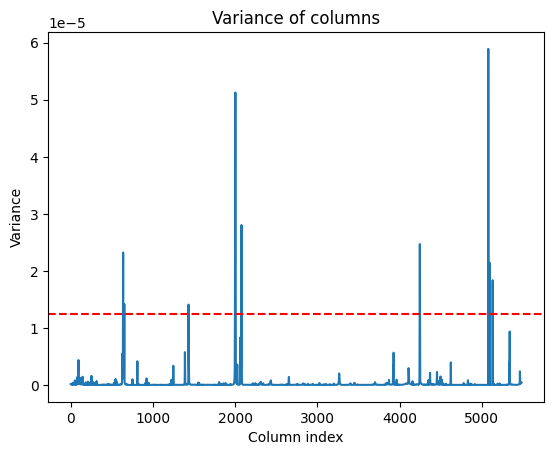

Threshold: 1.2640024431913335e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 690)
Transformed Test data shape: (390, 690)
Sum: 496.1348186177064
Number of columns dropped due to zero variance: 5454


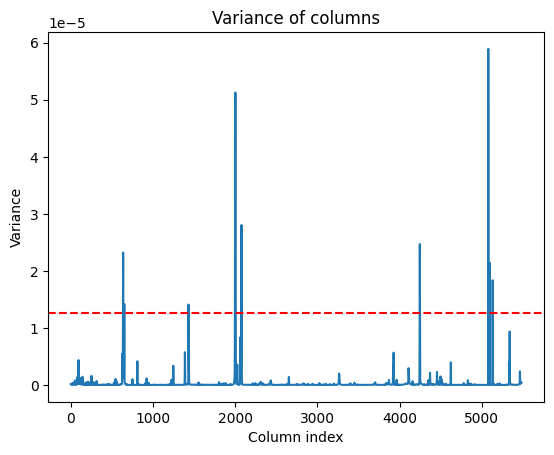

Threshold: 1.282544060752434e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 690)
Transformed Test data shape: (390, 690)
Sum: 496.1348186177064
Number of columns dropped due to zero variance: 5454


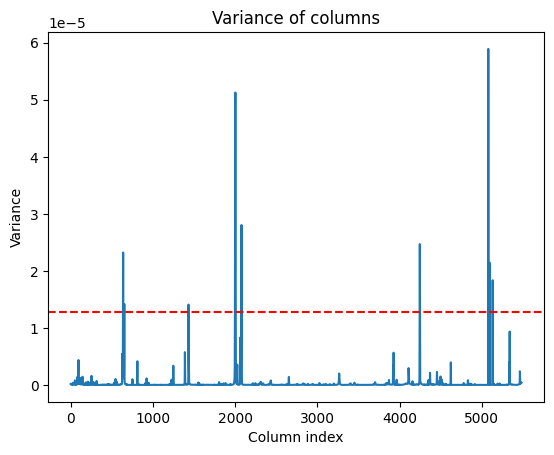

Threshold: 1.3005830797340293e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 690)
Transformed Test data shape: (390, 690)
Sum: 496.1348186177064
Number of columns dropped due to zero variance: 5454


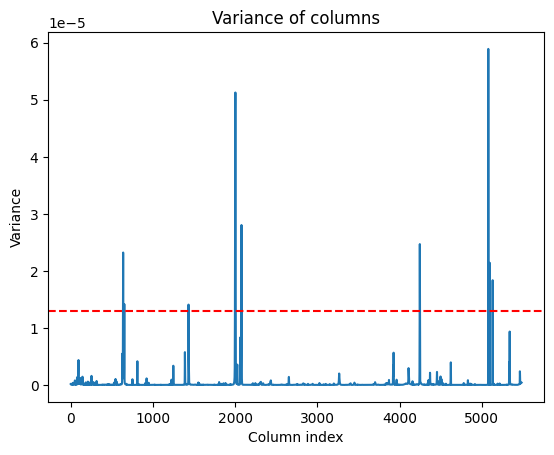

Threshold: 1.3188162451925152e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 690)
Transformed Test data shape: (390, 690)
Sum: 496.1348186177064
Number of columns dropped due to zero variance: 5454


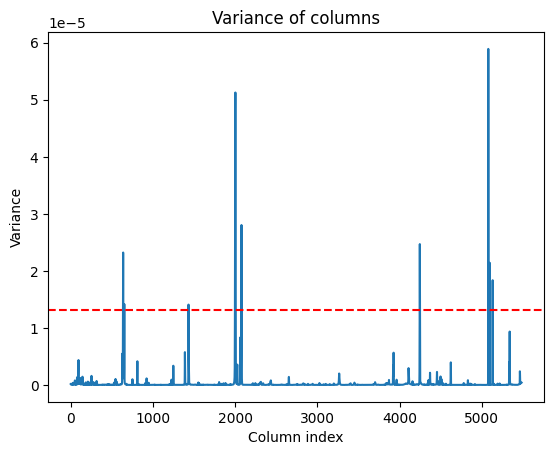

Threshold: 1.3361823596843393e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 689)
Transformed Test data shape: (390, 689)
Sum: 484.47387009597617
Number of columns dropped due to zero variance: 5455


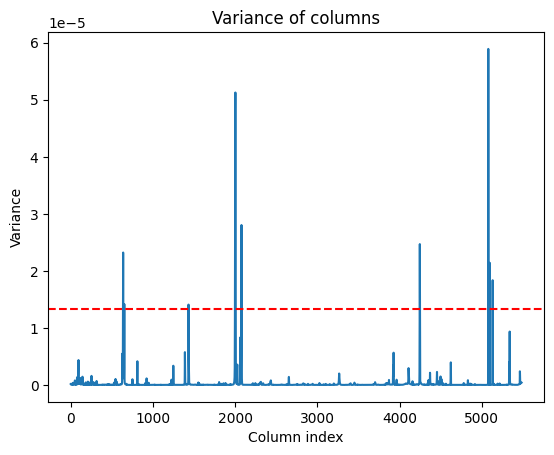

Threshold: 1.3539262759089716e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 688)
Transformed Test data shape: (390, 688)
Sum: 469.72922099309574
Number of columns dropped due to zero variance: 5456


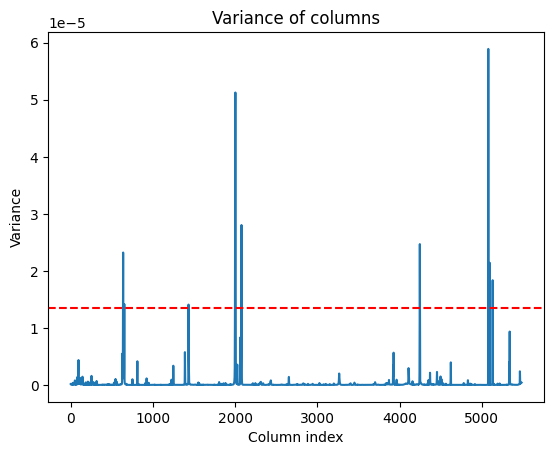

Threshold: 1.3713684116531806e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 688)
Transformed Test data shape: (390, 688)
Sum: 469.72922099309574
Number of columns dropped due to zero variance: 5456


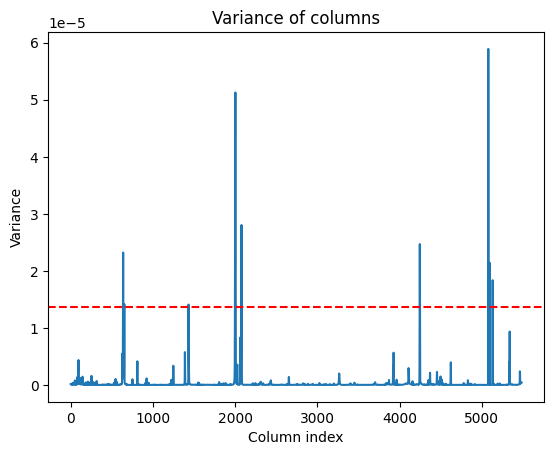

Threshold: 1.3883674194235683e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 688)
Transformed Test data shape: (390, 688)
Sum: 469.72922099309574
Number of columns dropped due to zero variance: 5456


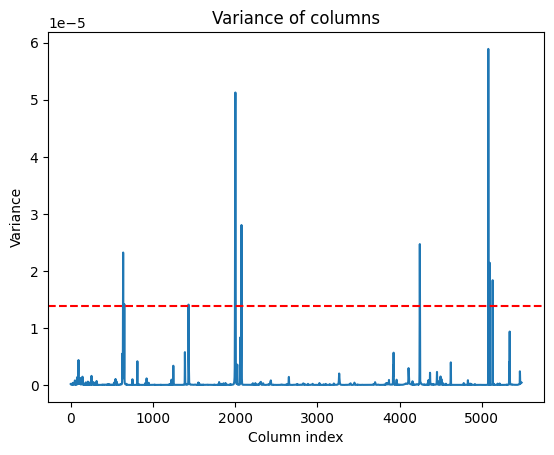

Threshold: 1.4049637766000034e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 687)
Transformed Test data shape: (390, 687)
Sum: 434.4652307506029
Number of columns dropped due to zero variance: 5457


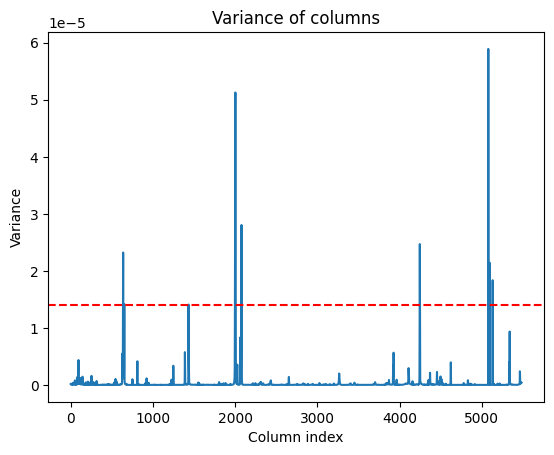

Threshold: 1.4225644715806761e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 685)
Transformed Test data shape: (390, 685)
Sum: 415.03949495480805
Number of columns dropped due to zero variance: 5459


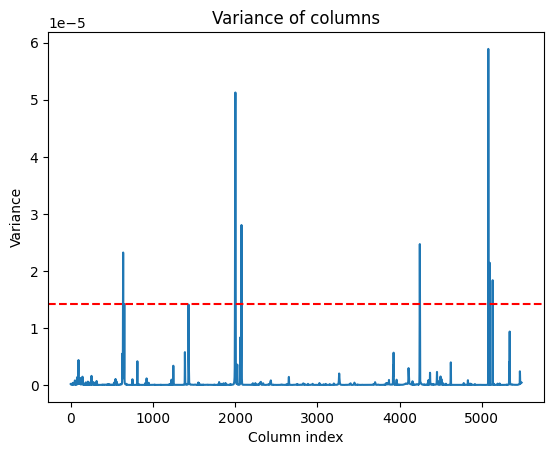

Threshold: 1.4401191276594625e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 684)
Transformed Test data shape: (390, 684)
Sum: 400.8314128927543
Number of columns dropped due to zero variance: 5460


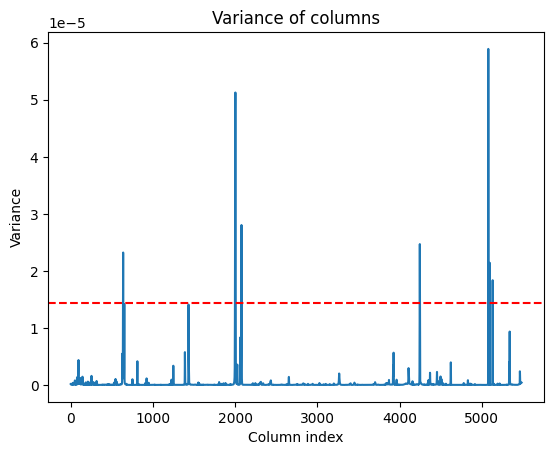

Threshold: 1.4569529791815435e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 684)
Transformed Test data shape: (390, 684)
Sum: 400.8314128927543
Number of columns dropped due to zero variance: 5460


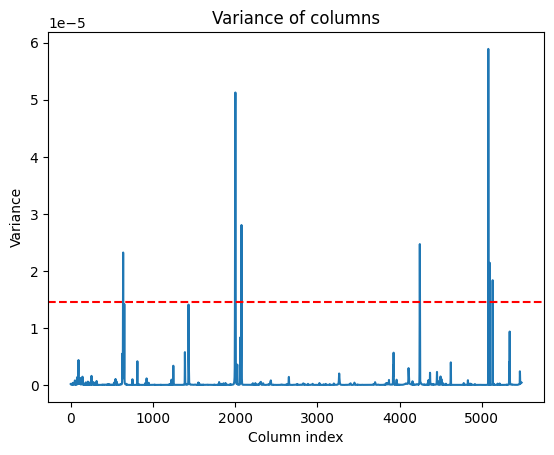

Threshold: 1.4741685852089479e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 684)
Transformed Test data shape: (390, 684)
Sum: 400.8314128927543
Number of columns dropped due to zero variance: 5460


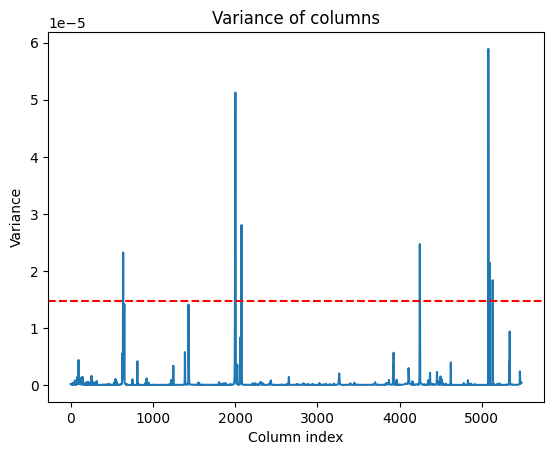

Threshold: 1.4910376339721167e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 684)
Transformed Test data shape: (390, 684)
Sum: 400.8314128927543
Number of columns dropped due to zero variance: 5460


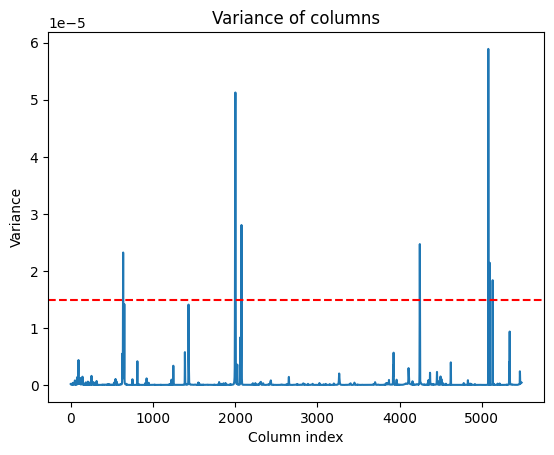

Threshold: 1.5079227299045165e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 684)
Transformed Test data shape: (390, 684)
Sum: 400.8314128927543
Number of columns dropped due to zero variance: 5460


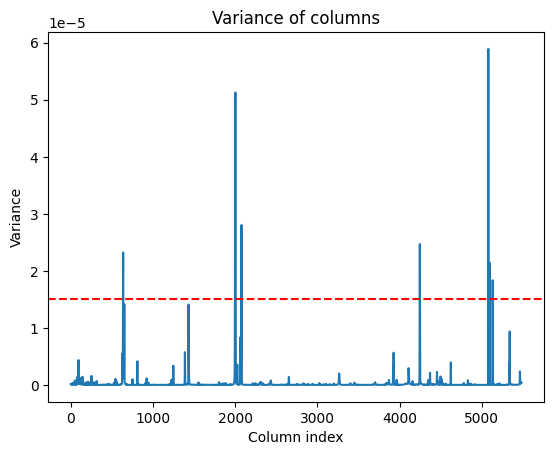

Threshold: 1.5246752871894465e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 684)
Transformed Test data shape: (390, 684)
Sum: 400.8314128927543
Number of columns dropped due to zero variance: 5460


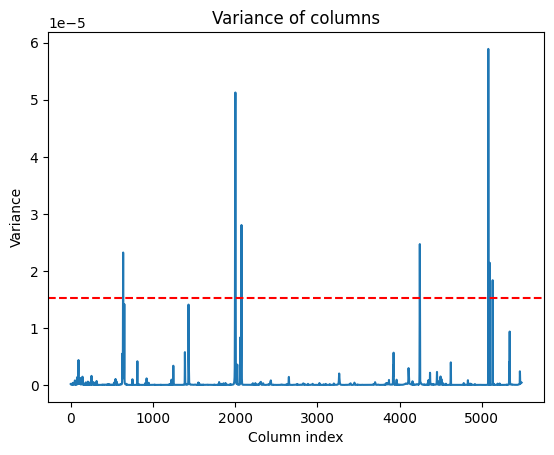

Threshold: 1.541894112559315e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 684)
Transformed Test data shape: (390, 684)
Sum: 400.8314128927543
Number of columns dropped due to zero variance: 5460


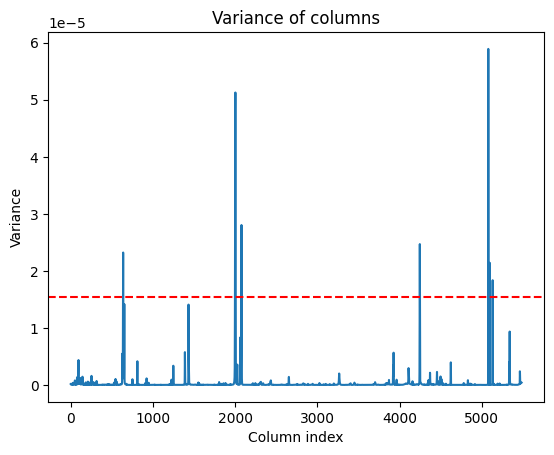

Threshold: 1.5580194256403847e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 684)
Transformed Test data shape: (390, 684)
Sum: 400.8314128927543
Number of columns dropped due to zero variance: 5460


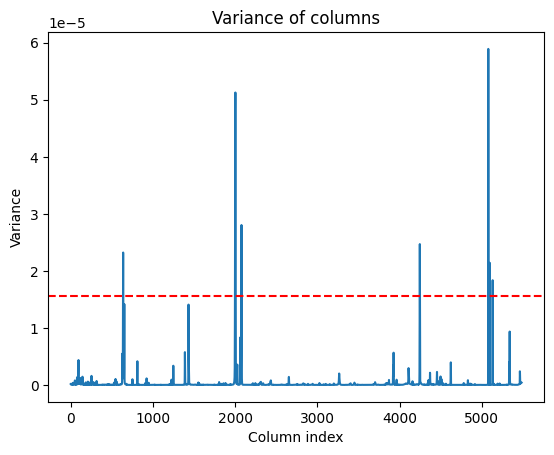

Threshold: 1.5739217503946057e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 684)
Transformed Test data shape: (390, 684)
Sum: 400.8314128927543
Number of columns dropped due to zero variance: 5460


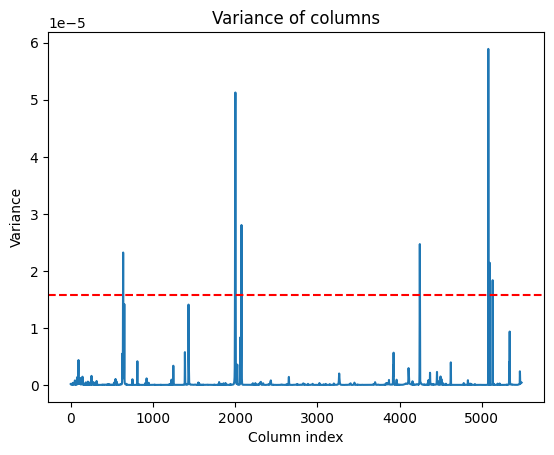

Threshold: 1.590364183943737e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 684)
Transformed Test data shape: (390, 684)
Sum: 400.8314128927543
Number of columns dropped due to zero variance: 5460


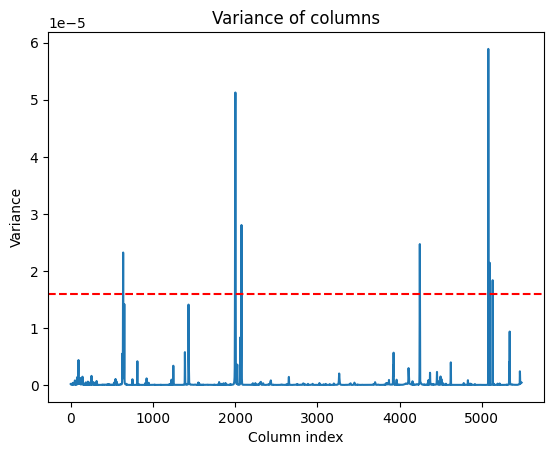

Threshold: 1.6070798371863977e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 684)
Transformed Test data shape: (390, 684)
Sum: 400.8314128927543
Number of columns dropped due to zero variance: 5460


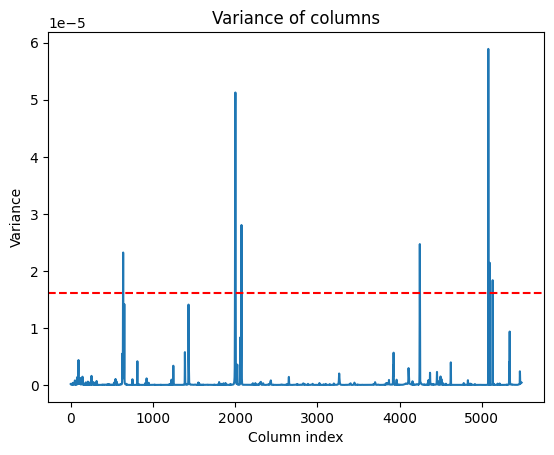

Threshold: 1.6227750054484914e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 684)
Transformed Test data shape: (390, 684)
Sum: 400.8314128927543
Number of columns dropped due to zero variance: 5460


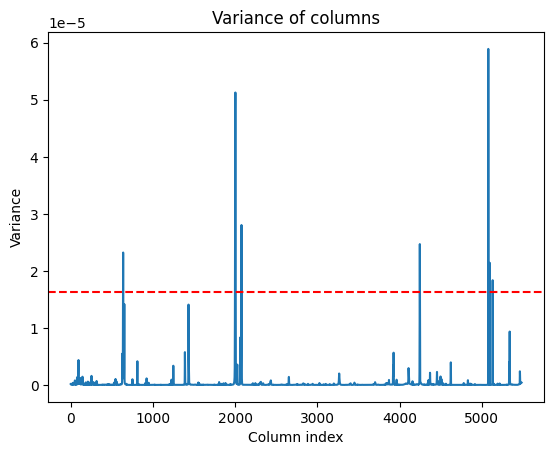

Threshold: 1.6381791687540738e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 684)
Transformed Test data shape: (390, 684)
Sum: 400.8314128927543
Number of columns dropped due to zero variance: 5460


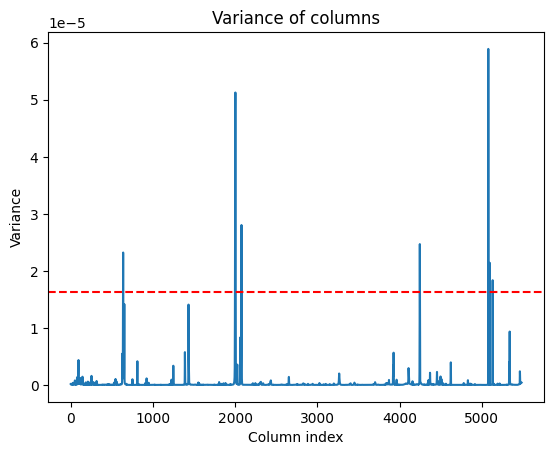

Threshold: 1.654384855112161e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 684)
Transformed Test data shape: (390, 684)
Sum: 400.8314128927543
Number of columns dropped due to zero variance: 5460


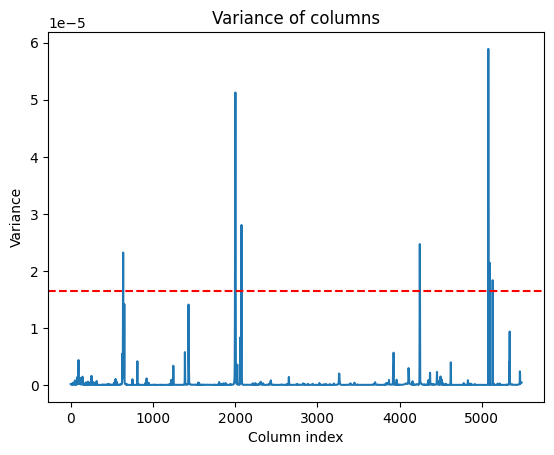

Threshold: 1.6712614513613388e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 683)
Transformed Test data shape: (390, 683)
Sum: 390.7375486127391
Number of columns dropped due to zero variance: 5461


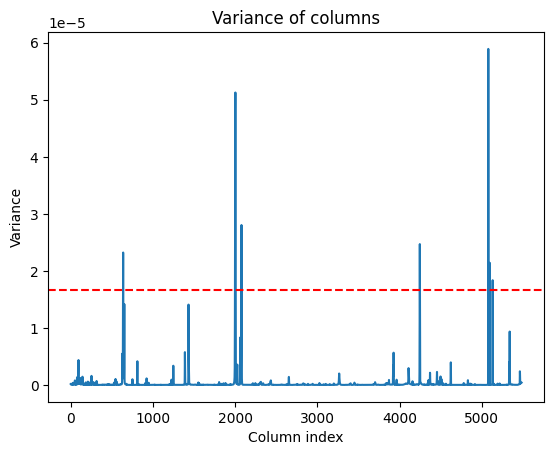

Threshold: 1.688032391417905e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 683)
Transformed Test data shape: (390, 683)
Sum: 390.7375486127391
Number of columns dropped due to zero variance: 5461


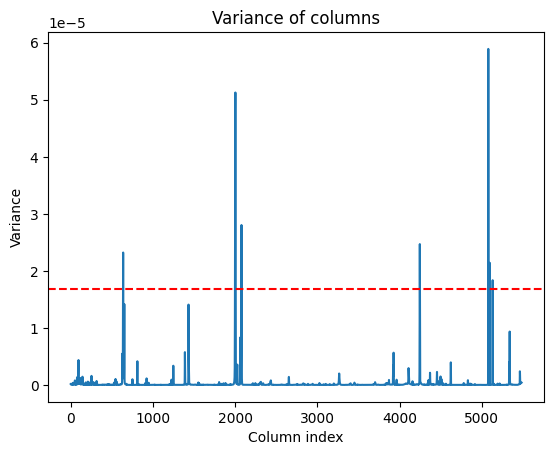

Threshold: 1.704603126957934e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 683)
Transformed Test data shape: (390, 683)
Sum: 390.7375486127391
Number of columns dropped due to zero variance: 5461


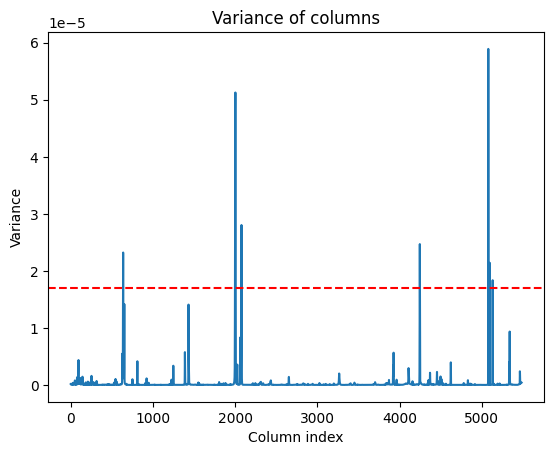

Threshold: 1.7217236592011954e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 683)
Transformed Test data shape: (390, 683)
Sum: 390.7375486127391
Number of columns dropped due to zero variance: 5461


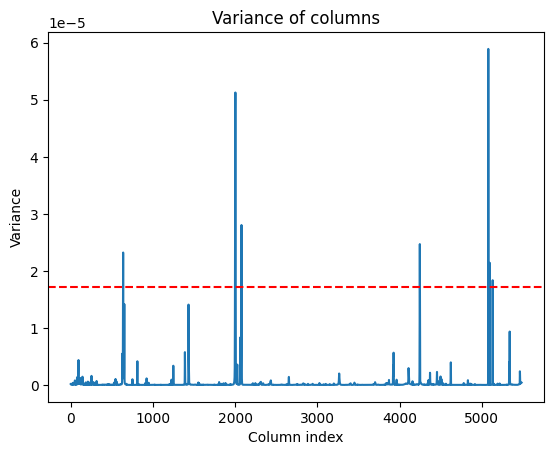

Threshold: 1.7372100324141294e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 683)
Transformed Test data shape: (390, 683)
Sum: 390.7375486127391
Number of columns dropped due to zero variance: 5461


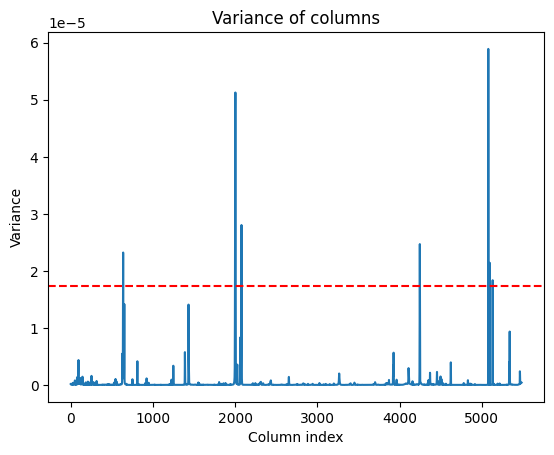

Threshold: 1.7534454710948434e-05
Original Training data shape: (1538, 6144)
Original Test data shape: (390, 6144)
Transformed Training data shape: (1538, 683)
Transformed Test data shape: (390, 683)
Sum: 390.7375486127391
Number of columns dropped due to zero variance: 5461


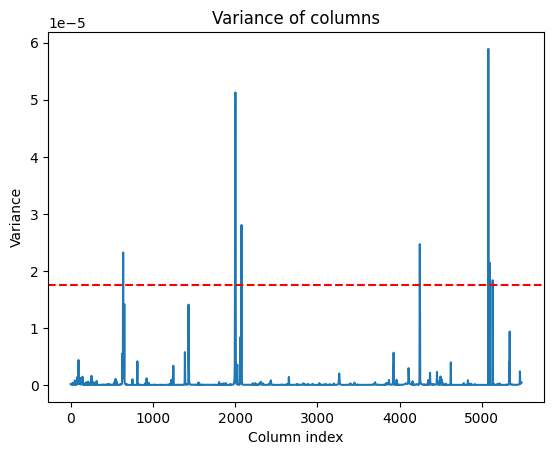

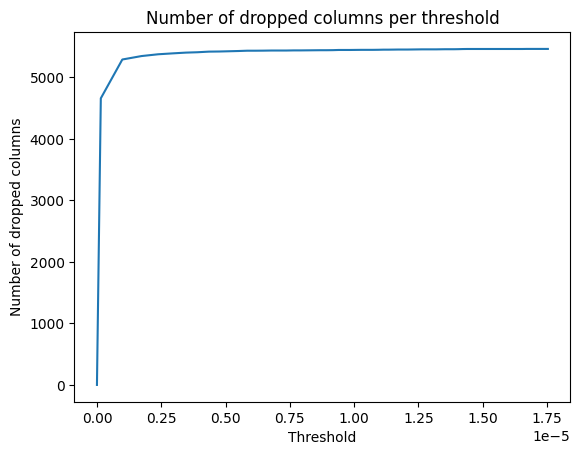

In [144]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

import matplotlib.pyplot as plt

num_dropped_colums_per_iteration = []

for i, threshold in enumerate(quantiles.values):
	# Identify columns where the sum is zero (these columns contain only zero)
	zero_sum_columns = train.columns[(train.sum(axis=0) == 0)]

	# Drop zero sum columns from train and test, keeping the original for later
	train_reduced = train.drop(columns=zero_sum_columns)
	test_reduced = test.drop(columns=zero_sum_columns)

	selector = VarianceThreshold(threshold=threshold)
	train_transformed = selector.fit_transform(train_reduced)
	test_transformed = selector.transform(test_reduced)

	# Prepare DataFrame from the numpy arrays returned by VarianceThreshold
	train_transformed_df = pd.DataFrame(train_transformed, columns=train_reduced.columns[selector.get_support()])
	test_transformed_df = pd.DataFrame(test_transformed, columns=test_reduced.columns[selector.get_support()])

	# Add back the zero-sum columns with all zeros
	for column in zero_sum_columns:
		train_transformed_df[column] = 0
		test_transformed_df[column] = 0

	# Ensure the column order is the same as the original DataFrames
	# train_final = train_transformed_df[train.columns]
	# test_final = test_transformed_df[test.columns]

	# Identify columns dropped due to zero variance (after removing zero sum columns)
	dropped_variance_columns = train_reduced.columns[~selector.get_support()]

	# Printing the shape of the data before and after transformation
	print(f"Threshold: {threshold}")
	# Print the variance
	# print(f"Variance of each column: {selector.variances_}")

	# Print the min of the variance
	# print(f"Min Variance: {selector.variances_.min()}")

	print(f"Original Training data shape: {train.shape}")
	print(f"Original Test data shape: {test.shape}")
	print(f"Transformed Training data shape: {train_transformed_df.shape}")
	print(f"Transformed Test data shape: {test_transformed_df.shape}")
	print(f"Sum: {train_transformed_df.sum().sum()}")

	# Print the number of columns dropped due to zero variance
	print(f"Number of columns dropped due to zero variance: {len(dropped_variance_columns)}")

	num_dropped_colums_per_iteration.append(len(dropped_variance_columns))
	plt.plot(selector.variances_)
	plt.xlabel("Column index")
	plt.ylabel("Variance")
	plt.title("Variance of columns")
	plt.axhline(y=threshold, color='r', linestyle='--')

	plt.show()

# plot the number of dropped columns per iteration
plt.plot(quantiles, num_dropped_colums_per_iteration)
plt.xlabel("Threshold")
plt.ylabel("Number of dropped columns")
plt.title("Number of dropped columns per threshold")
plt.show()

In [135]:
train_transformed_df.iloc[:, 200:300]
print(train.sum(axis=0).sum())
print(train_transformed_df.sum(axis=0).sum())

4614.0
390.7375486127391


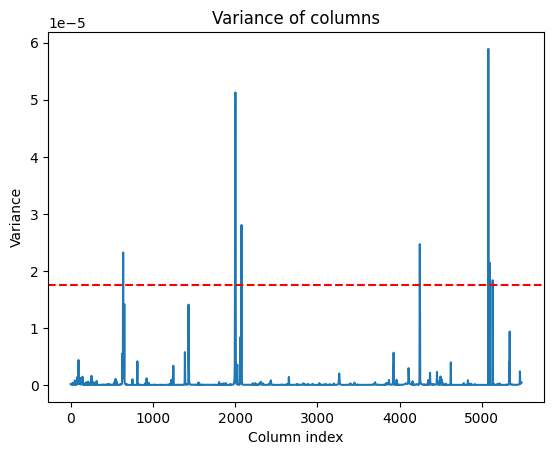

In [136]:
plt.plot(selector.variances_)
plt.xlabel("Column index")
plt.ylabel("Variance")
plt.title("Variance of columns")
plt.axhline(y=threshold, color='r', linestyle='--')

plt.show()

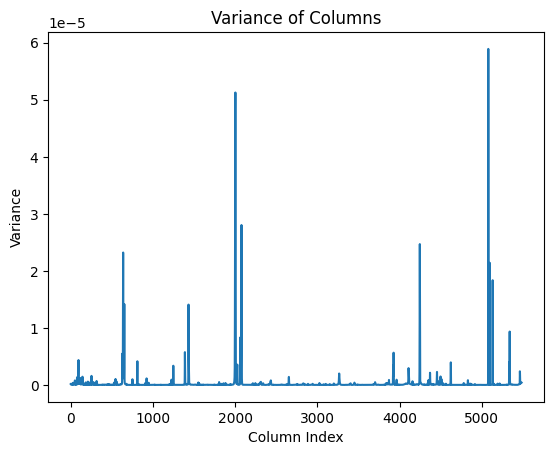

KeyError: 0

In [140]:
from matplotlib.animation import FuncAnimation
variances = selector.variances_
thresholds = quantiles

fig, ax = plt.subplots()
ax.plot(variances, label='Column Variances')
ax.set_xlabel("Column Index")
ax.set_ylabel("Variance")
ax.set_title("Variance of Columns")
line, = ax.plot([], [], 'r--', label='Threshold')  # This line will be updated in the animation

# Initialization function for the animation
def init():
    line.set_data([], [])
    return line,

# Animation update function
def update(frame):
    line.set_data([0, len(variances) - 1], [thresholds[frame], thresholds[frame]])
    ax.legend()
    return line,

# Creating the animation
ani = FuncAnimation(fig, update, frames=len(thresholds), init_func=init, blit=True)
plt.show()

ani.save('animation.mp4', writer='ffmpeg', fps=1)
